In [1]:
!pip install aicsimageio[nd2]
!pip install nd2reader
!pip install xlsxwriter

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Check OpenCV version
import cv2
cv2.__version__

'4.5.4'

In [2]:
# Import required libraries
from pathlib import Path
import napari
from napari.settings import get_settings
import pandas as pd
import os
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from scipy import ndimage as ndi
from scipy.ndimage import label #, find_objects
from skimage.segmentation import relabel_sequential
from itertools import combinations
from skimage import filters, morphology
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from vispy.color import Colormap
from matplotlib.colors import to_rgb
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from collections import defaultdict
from aicsimageio import AICSImage
from nd2reader import ND2Reader
from scipy.ndimage import zoom
import meshlib.mrmeshpy as mr
import meshlib.mrmeshnumpy as mrn
from IPython.display import clear_output
from scipy.ndimage import binary_dilation, generate_binary_structure
import meshio
import statistics as st
import tetgen
from skimage.morphology import ball
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola
import xlsxwriter

from skimage.measure import regionprops

# Enable interactive mode for napari in Jupyter
settings = get_settings()
settings.application.ipy_interactive = True

import numpy as np
from stardist.models import StarDist2D
from csbdeep.utils import normalize
#from skimage.measure import label
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

2026-01-28 11:34:50.377862: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-28 11:34:50.386768: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-28 11:34:50.470980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-28 11:34:51.834779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [30]:
from pathlib import Path
import napari
from napari.settings import get_settings
import pandas as pd
import os
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import SimpleITK as sitk
import skimage
from scipy import ndimage as ndi
from scipy.ndimage import label, zoom, binary_dilation, generate_binary_structure
from skimage.segmentation import watershed, relabel_sequential
from itertools import combinations
from skimage import filters, morphology
from skimage.feature import peak_local_max
from vispy.color import Colormap
from matplotlib.colors import to_rgb
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from collections import defaultdict
from aicsimageio import AICSImage
from nd2reader import ND2Reader
import meshlib.mrmeshpy as mr
import meshlib.mrmeshnumpy as mrn
from IPython.display import clear_output
import meshio
import statistics as st
import tetgen
from skimage.morphology import ball
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola
import xlsxwriter
from skimage.measure import regionprops
from scipy.stats import gaussian_kde
from PIL import Image as PILImage
from reportlab.platypus import Image as RLImage
from reportlab.platypus import (
    SimpleDocTemplate, Image, Paragraph, Spacer, Table, TableStyle, PageBreak
)
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

# Enable interactive mode for napari in Jupyter
settings = get_settings()
settings.application.ipy_interactive = True

#### Functions

In [31]:
# Image processing and utility functions

def gamma_trans(im_in, gamma):
    """Apply gamma correction to an image."""
    val_c = 255.0 / (np.max(im_in)**gamma)
    return (val_c * (im_in**gamma)).copy()

def napari_gamma(image, gamma):
    """
    Apply gamma correction in the same way as Napari.

    Parameters
    ----------
    image : numpy.ndarray
        2D or 3D image, integer or float.
        If integer, assumed to be full-range (uint8, uint16).
    gamma : float
        Same gamma exponent used in Napari.

    Returns
    -------
    corrected : numpy.ndarray
        Gamma-corrected image with the same dtype as input.
    """

    # preserve original dtype to restore at the end
    dtype = image.dtype

    # convert to float in [0,1]
    img = image.astype(np.float32)
    img /= img.max() if img.max() != 0 else 1.0

    # apply gamma
    img = img ** gamma

    # rescale back to original dtype range
    if np.issubdtype(dtype, np.integer):
        info = np.iinfo(dtype)
        img = np.clip(img * info.max, 0, info.max).astype(dtype)
    else:
        img = img.astype(dtype)

    return img

def contr_limit(im_in, c_min=None, c_max=None):
    """
    Stretch the contrast of the input image to the 0–255 range.
    
    Parameters:
    - im_in: Input image (NumPy array).
    - c_min: Minimum intensity to map to 0. If None, uses im_in.min().
    - c_max: Maximum intensity to map to 255. If None, uses im_in.max().
    
    Returns:
    - Contrast-stretched image (uint8).
    """
    im_in = im_in.astype(float)
    
    if c_min is None:
        c_min = im_in.min()
    if c_max is None:
        c_max = im_in.max()
    
    if c_max == c_min:
        return np.zeros_like(im_in, dtype=np.uint8)  # avoid division by zero

    alpha = 255.0 / (c_max - c_min)
    beta = -c_min * alpha

    im_out = alpha * im_in + beta
    #return np.clip(im_out, 0, 255).astype(np.uint8)
    return (im_out).astype(np.uint8)

def contr_stretch(im_in, c_min=None, c_max=None):
    """
    Mimic Fiji's Brightness/Contrast adjustment.
    Values below min_input become 0.
    Values above max_input become 255.
    Values in between are linearly scaled to 0–255.
    
    Parameters:
    - im_in: Input image (NumPy array).
    - min_input: Input value to be mapped to 0.
    - max_input: Input value to be mapped to 255.
    
    Returns:
    - Adjusted image (uint8).
    """
    im_in = im_in.astype(float)

    if c_min is None:
        c_min = im_in.min()
    if c_max is None:
        c_max = im_in.max()
    
    if c_max == c_min:
        return np.zeros_like(im_in, dtype=np.uint8)  # avoid division by zero

    # Normalize: subtract min and divide by (max - min)
    norm = (im_in - c_min) / (c_max - c_min)
    
    # Clip to [0, 1] so values outside range are fixed to 0 or 1
    norm = np.clip(norm, 0, 1)
    
    return (norm * 255).astype(np.uint8)

def napari_contrast_gamma_uint8(image, contrast_limits, gamma):
    """
    Apply Napari-style contrast limits + gamma correction,
    and return the resulting image as uint8.

    Parameters
    ----------
    image : np.ndarray
        Input image (any dtype).
    contrast_limits : tuple (clim_min, clim_max)
        Same values you see in Napari GUI.
    gamma : float
        Gamma value from Napari GUI.

    Returns
    -------
    out_uint8 : np.ndarray (uint8)
        Image transformed exactly like Napari display,
        then mapped to 0–255.
    """

    clim_min, clim_max = contrast_limits

    # Convert to float
    img = image.astype(np.float32)

    # Napari contrast normalization
    img = (img - clim_min) / (clim_max - clim_min)
    img = np.clip(img, 0.0, 1.0)

    # Napari gamma
    img = img ** gamma

    # Convert display range [0,1] → uint8 [0,255]
    out_uint8 = (img * 255).round().astype(np.uint8)

    return out_uint8

def hist_plot(im_in, stain_complete_df, thresh=0):
    """Plot histogram and CDF for each channel."""
    fig, axs = plt.subplots(1, im_in.shape[3], figsize=(15, 2))
    for c in range(im_in.shape[3]):
        hist, _ = np.histogram(im_in[:, :, :, c].flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()
        color = stain_complete_df.loc[stain_complete_df.index[c], 'Color']
        axs[c].plot(cdf_normalized, color='b')
        axs[c].hist(im_in[:, :, :, c].flatten(), 256, [0, 256], color=color if color != 'WHITE' else 'GRAY')
        axs[c].set_xlim([0, 256])
        axs[c].legend(('cdf', 'histogram'), loc='upper left')
        if thresh > 0:
            axs[c].plot([thresh, thresh], [0, cdf_normalized.max()], color='g')
        axs[c].set_title(stain_complete_df.index[c])
        axs[c].set_yscale('log')

def truncate_cell(val, width=15):
    """Truncate long values for display in tables."""
    val_str = str(val)
    return val_str if len(val_str) <= width else val_str[:width-3] + "..."

def merge_touching_labels(label_matrix):
    """Merge touching labels in a 3D label matrix using union-find."""
    if label_matrix.max() == 0:
        return label_matrix.copy()

    padded = np.pad(label_matrix, 1, mode='constant', constant_values=0)
    touching = defaultdict(set)

    # Iterate over the inner volume (excluding padding)
    for z in range(1, padded.shape[0] - 1):
        for y in range(1, padded.shape[1] - 1):
            for x in range(1, padded.shape[2] - 1):
                center = padded[z, y, x]
                if center == 0:
                    continue
                neighborhood = padded[z-1:z+2, y-1:y+2, x-1:x+2].ravel()
                for neighbor in neighborhood:
                    if neighbor != center and neighbor != 0:
                        touching[center].add(neighbor)

    # Union-Find to merge touching labels
    all_labels = set(np.unique(label_matrix)) - {0}
    parent = {label: label for label in all_labels}

    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u

    def union(u, v):
        pu, pv = find(u), find(v)
        if pu != pv:
            parent[pu] = pv

    for u, neighbors in touching.items():
        for v in neighbors:
            if u in parent and v in parent:
                union(u, v)

    label_map = {label: find(label) for label in all_labels}

    # Apply merged labels
    merged = np.zeros_like(label_matrix, dtype=np.int32)
    for label, root in label_map.items():
        merged[label_matrix == label] = root

    # Re-label to get sequential labels starting from 1
    merged, _, _ = relabel_sequential(merged)
    return merged

def remove_small_islands(binary_matrix, area_threshold):
    """Remove small connected components from a binary mask."""
    labeled_array, num_features = label(binary_matrix)
    for i in range(1, num_features + 1):
        component = (labeled_array == i)
        if component.sum() < area_threshold:
            binary_matrix[component] = 0
    return binary_matrix

def assign_labels(A, B, connectivity=1):
    """Assign labels from B to islands in A based on overlap (3D)."""
    if connectivity == 2:
        structure = np.ones((3, 3, 3))  # 26-connectivity
    else:
        structure = None  # default is 6-connectivity for 3D

    labeled_A, num_features = label(A, structure=structure)
    C = np.zeros_like(A, dtype=B.dtype)

    for i in range(1, num_features + 1):
        mask = labeled_A == i
        overlapping_labels = np.unique(B[mask & (B > 0)])
        C[mask] = overlapping_labels[0] if len(overlapping_labels) > 0 else 0

    return C

def grow_labels(label_matrix,volume_factor=5.0):
    structure = ball(volume_factor) #generate_binary_structure(3, 1)  # 6-connectivity in 3D
    output = label_matrix.copy()
    
    labels = np.unique(label_matrix)
    labels = labels[labels != 0]  # exclude background

    # Compute original volumes
    volumes = {label: np.sum(label_matrix == label) for label in labels}
    target_volumes = {label: volume_factor * vol for label, vol in volumes.items()}

    # Create masks for each label
    label_masks = {label: (label_matrix == label) for label in labels}
    grown_masks = label_masks.copy()

    # Initialize growing flags
    growing = {label: True for label in labels}

    # Start growing iterations
    while any(growing.values()):
        new_masks = {}
        occupied = np.zeros_like(label_matrix, dtype=bool)

        # Prepare current occupied space
        for label, mask in grown_masks.items():
            occupied |= mask

        for label in labels:
            if not growing[label]:
                continue
            # Grow
            dilated = binary_dilation(grown_masks[label], structure)
            # Only grow into free space
            new_mask = dilated & ~occupied
            combined = grown_masks[label] | new_mask
            if np.sum(combined) >= target_volumes[label]:
                growing[label] = False
            grown_masks[label] = combined
            new_masks[label] = combined

        # Update output matrix
        output[:] = 0
        for label, mask in grown_masks.items():
            output[mask] = label

    return output

def stardist3d_from_2d(
    img_3d,
    model_name="2D_versatile_fluo",
    nucleus_radius=5,
    voxel_size=(1.0, 0.5, 0.5),
    norm=True,
):
    """
    Apply StarDist2D slice-by-slice to a 3D stack, merge predictions,
    and split weakly connected nuclei using distance-based watershed.
    Handles anisotropic voxel spacing.

    Parameters
    ----------
    img_3d : np.ndarray
        Input 3D grayscale image, shape (Z, Y, X).
    model_name : str
        Name of pretrained StarDist2D model.
    nucleus_radius : float
        Approximate radius of nuclei in pixels (XY units).
    voxel_size : tuple(float)
        Physical voxel size as (z_spacing, y_spacing, x_spacing).
    norm : bool
        Normalize each 2D slice before prediction.

    Returns
    -------
    labels_split : np.ndarray
        3D labeled array (int32), same shape as input.
    """

    assert img_3d.ndim == 3, "Input must be 3D (Z, Y, X)"
    z_spacing, y_spacing, x_spacing = voxel_size

    print(f"Running StarDist2D on {img_3d.shape[0]} z-slices...")
    model = StarDist2D.from_pretrained(model_name)

    labels_3d = np.zeros_like(img_3d, dtype=np.int32)
    current_label = 1

    for z in range(img_3d.shape[0]):
        img = img_3d[z]
        if norm:
            img = normalize(img, 1, 99.8, axis=None)

        labels2d, _ = model.predict_instances(img)
        labels2d = np.where(labels2d > 0, labels2d + current_label, 0)
        labels_3d[z] = labels2d
        current_label = labels2d.max() + 1

    # Merge touching objects in 3D
    labels_3d = skimage.measure.label(labels_3d > 0, connectivity=1)

    # --- Anisotropic distance-based splitting ---
    print("Computing distance transform with anisotropic voxel spacing...")
    distance = ndi.distance_transform_edt(labels_3d > 0, sampling=voxel_size)

    # Estimate local maxima using nucleus_radius as search distance in XY
    footprint = np.ones(
        (
            max(1, int(z_spacing / y_spacing)),  # thin in z
            int(nucleus_radius),
            int(nucleus_radius),
        ),
        dtype=bool,
    )

    local_max = peak_local_max(
        distance,
        footprint=footprint,
        labels=labels_3d > 0,
        exclude_border=False,
    )

    # Create markers for watershed
    markers = np.zeros_like(labels_3d, dtype=int)
    for i, coord in enumerate(local_max, start=1):
        markers[tuple(coord)] = i

    # Watershed segmentation
    print("Running 3D watershed to split connected nuclei...")
    labels_split = watershed(-distance, markers, mask=labels_3d > 0)

    print(f"Done. Found {labels_split.max()} nuclei.")
    return labels_split


# def stardist3d_from_2d(model_name='2D_versatile_fluo', img_3d=None, norm=True):
#     """
#     Apply StarDist2D slice-by-slice to a 3D image stack and merge results.

#     Parameters
#     ----------
#     model_name : str
#         Name of pretrained StarDist2D model (e.g. '2D_versatile_fluo').
#     img_3d : np.ndarray
#         Input 3D image of shape (Z, Y, X).
#     norm : bool
#         Whether to normalize each slice individually.

#     Returns
#     -------
#     labels_3d : np.ndarray
#         3D labeled array of the same shape as img_3d.
#     """

#     assert img_3d.ndim == 3, "Input must be a 3D array (Z, Y, X)."

#     # Load pretrained 2D model
#     model = StarDist2D.from_pretrained(model_name)

#     labels_3d = np.zeros_like(img_3d, dtype=np.int32)
#     current_label = 1

#     for z in range(img_3d.shape[0]):
#         img = img_3d[z]

#         if norm:
#             img = normalize(img, 1.0, 99.8, axis=None)

#         # Predict 2D nuclei
#         labels2d, _ = model.predict_instances(img)

#         # Re-label so all IDs are unique across z
#         labels2d = np.where(labels2d > 0, labels2d + current_label, 0)
#         labels_3d[z] = labels2d
#         current_label = labels2d.max() + 1

#     # Optionally merge across z slices using 3D connectivity
#     labels_3d = skimage.measure.label(labels_3d > 0, connectivity=1)

#     return labels_3d

def make_anisotropic_footprint(radius_Z, radius_Y, radius_X):
    zz, yy, xx = np.ogrid[
        -radius_Z:radius_Z+1,
        -radius_Y:radius_Y+1,
        -radius_X:radius_X+1
    ]
    ellipsoid = ((zz / radius_Z)**2 + (yy / radius_Y)**2 + (xx / radius_X)**2) <= 1
    return ellipsoid

def merge_small_touching_labels(label_matrix, size_threshold, z_weight=2.0):
    """
    Merge small 3D labeled regions (< size_threshold) with touching neighbors,
    preferentially merging into the largest touching label.
    Large labels remain untouched.

    Parameters
    ----------
    label_matrix : np.ndarray (3D)
        Labeled 3D array (e.g., watershed segmentation output).
    size_threshold : int
        Maximum voxel volume for a region to be considered "small".
    z_weight : float, optional (default=2.0)
        Weight factor to penalize Z-direction adjacency.
        Use >1 for anisotropic stacks (Z spacing larger than XY).
        Example: if Z spacing = 2 µm and XY = 0.5 µm, z_weight ≈ 4.

    Returns
    -------
    merged : np.ndarray (3D)
        Relabeled 3D matrix where small touching regions are merged
        into larger neighbors, and all labels are renumbered sequentially.
    """

    if label_matrix.max() == 0:
        return label_matrix.copy()

    # --- Step 1: Compute region properties ---
    props = regionprops(label_matrix)
    sizes = {p.label: p.area for p in props}
    small_labels = {lbl for lbl, area in sizes.items() if area < size_threshold}

    # --- Step 2: Build adjacency map (touching neighbors) ---
    padded = np.pad(label_matrix, 1, mode='constant', constant_values=0)
    touching = defaultdict(set)

    z_range = [-1, 0, 1]
    y_range = [-1, 0, 1]
    x_range = [-1, 0, 1]

    # Weighted neighborhood exploration for anisotropy
    for z in range(1, padded.shape[0] - 1):
        for y in range(1, padded.shape[1] - 1):
            for x in range(1, padded.shape[2] - 1):
                center = padded[z, y, x]
                if center == 0:
                    continue

                # Explore 26-neighborhood
                for dz in z_range:
                    for dy in y_range:
                        for dx in x_range:
                            if dz == dy == dx == 0:
                                continue
                            neighbor = padded[z + dz, y + dy, x + dx]
                            if neighbor == 0 or neighbor == center:
                                continue

                            # Apply anisotropic penalty: skip weak Z contacts
                            if abs(dz) == 1 and (abs(dx) + abs(dy)) == 0:
                                if np.random.random() < 1 / z_weight:
                                    touching[center].add(neighbor)
                            else:
                                touching[center].add(neighbor)

    # --- Step 3: Merge small regions with largest touching neighbor ---
    merged = label_matrix.copy()

    for lbl in sorted(small_labels):
        mask = (merged == lbl)
        if not np.any(mask):
            continue

        neighbors = touching.get(lbl, set())
        if not neighbors:
            continue

        # Choose the largest touching neighbor (prefer large ones)
        neighbor_sizes = {n: sizes.get(n, 0) for n in neighbors if n not in small_labels}
        if len(neighbor_sizes) == 0:
            # If all neighbors are small, merge with the largest among them
            neighbor_sizes = {n: sizes.get(n, 0) for n in neighbors}

        if len(neighbor_sizes) == 0:
            continue  # isolated small label

        target_label = max(neighbor_sizes, key=neighbor_sizes.get)
        merged[mask] = target_label

    # --- Step 4: Relabel sequentially starting from 1 ---
    merged, _, _ = relabel_sequential(merged)
    return merged

In [ ]:
# Image processing and utility functions

def gamma_trans(im_in, gamma):
    """Apply gamma correction to an image."""
    val_c = 255.0 / (np.max(im_in)**gamma)
    return (val_c * (im_in**gamma)).copy()

def contr_limit(im_in, c_min=None, c_max=None):
    """
    Stretch the contrast of the input image to the 0–255 range.
    
    Parameters:
    - im_in: Input image (NumPy array).
    - c_min: Minimum intensity to map to 0. If None, uses im_in.min().
    - c_max: Maximum intensity to map to 255. If None, uses im_in.max().
    
    Returns:
    - Contrast-stretched image (uint8).
    """
    im_in = im_in.astype(float)
    
    if c_min is None:
        c_min = im_in.min()
    if c_max is None:
        c_max = im_in.max()
    
    if c_max == c_min:
        return np.zeros_like(im_in, dtype=np.uint8)  # avoid division by zero

    alpha = 255.0 / (c_max - c_min)
    beta = -c_min * alpha

    im_out = alpha * im_in + beta
    return np.clip(im_out, 0, 255).astype(np.uint8)

def contr_stretch(im_in, c_min=None, c_max=None):
    """
    Mimic Fiji's Brightness/Contrast adjustment.
    Values below min_input become 0.
    Values above max_input become 255.
    Values in between are linearly scaled to 0–255.
    
    Parameters:
    - im_in: Input image (NumPy array).
    - min_input: Input value to be mapped to 0.
    - max_input: Input value to be mapped to 255.
    
    Returns:
    - Adjusted image (uint8).
    """
    im_in = im_in.astype(float)

    if c_min is None:
        c_min = im_in.min()
    if c_max is None:
        c_max = im_in.max()
    
    if c_max == c_min:
        return np.zeros_like(im_in, dtype=np.uint8)  # avoid division by zero

    # Normalize: subtract min and divide by (max - min)
    norm = (im_in - c_min) / (c_max - c_min)
    
    # Clip to [0, 1] so values outside range are fixed to 0 or 1
    norm = np.clip(norm, 0, 1)
    
    return (norm * 255).astype(np.uint8)

def hist_plot(im_in, stain_complete_df, thresh=0):
    """Plot histogram and CDF for each channel."""
    fig, axs = plt.subplots(1, im_in.shape[3], figsize=(15, 2))
    for c in range(im_in.shape[3]):
        hist, _ = np.histogram(im_in[:, :, :, c].flatten(), 256, [0, 256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()
        color = stain_complete_df.loc[stain_complete_df.index[c], 'Color']
        axs[c].plot(cdf_normalized, color='b')
        axs[c].hist(im_in[:, :, :, c].flatten(), 256, [0, 256], color=color if color != 'WHITE' else 'GRAY')
        axs[c].set_xlim([0, 256])
        axs[c].legend(('cdf', 'histogram'), loc='upper left')
        if thresh > 0:
            axs[c].plot([thresh, thresh], [0, cdf_normalized.max()], color='g')
        axs[c].set_title(stain_complete_df.index[c])
        axs[c].set_yscale('log')

def truncate_cell(val, width=15):
    """Truncate long values for display in tables."""
    val_str = str(val)
    return val_str if len(val_str) <= width else val_str[:width-3] + "..."

def merge_touching_labels(label_matrix):
    """Merge touching labels in a 3D label matrix using union-find."""
    if label_matrix.max() == 0:
        return label_matrix.copy()

    padded = np.pad(label_matrix, 1, mode='constant', constant_values=0)
    touching = defaultdict(set)

    # Iterate over the inner volume (excluding padding)
    for z in range(1, padded.shape[0] - 1):
        for y in range(1, padded.shape[1] - 1):
            for x in range(1, padded.shape[2] - 1):
                center = padded[z, y, x]
                if center == 0:
                    continue
                neighborhood = padded[z-1:z+2, y-1:y+2, x-1:x+2].ravel()
                for neighbor in neighborhood:
                    if neighbor != center and neighbor != 0:
                        touching[center].add(neighbor)

    # Union-Find to merge touching labels
    all_labels = set(np.unique(label_matrix)) - {0}
    parent = {label: label for label in all_labels}

    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u

    def union(u, v):
        pu, pv = find(u), find(v)
        if pu != pv:
            parent[pu] = pv

    for u, neighbors in touching.items():
        for v in neighbors:
            if u in parent and v in parent:
                union(u, v)

    label_map = {label: find(label) for label in all_labels}

    # Apply merged labels
    merged = np.zeros_like(label_matrix, dtype=np.int32)
    for label, root in label_map.items():
        merged[label_matrix == label] = root

    # Re-label to get sequential labels starting from 1
    merged, _, _ = relabel_sequential(merged)
    return merged

def remove_small_islands(binary_matrix, area_threshold):
    """Remove small connected components from a binary mask."""
    labeled_array, num_features = label(binary_matrix)
    for i in range(1, num_features + 1):
        component = (labeled_array == i)
        if component.sum() < area_threshold:
            binary_matrix[component] = 0
    return binary_matrix

def assign_labels(A, B, connectivity=1):
    """Assign labels from B to islands in A based on overlap (3D)."""
    if connectivity == 2:
        structure = np.ones((3, 3, 3))  # 26-connectivity
    else:
        structure = None  # default is 6-connectivity for 3D

    labeled_A, num_features = label(A, structure=structure)
    C = np.zeros_like(A, dtype=B.dtype)

    for i in range(1, num_features + 1):
        mask = labeled_A == i
        overlapping_labels = np.unique(B[mask & (B > 0)])
        C[mask] = overlapping_labels[0] if len(overlapping_labels) > 0 else 0

    return C

def grow_labels(label_matrix,volume_factor=5.0):
    structure = ball(volume_factor) #generate_binary_structure(3, 1)  # 6-connectivity in 3D
    output = label_matrix.copy()
    
    labels = np.unique(label_matrix)
    labels = labels[labels != 0]  # exclude background

    # Compute original volumes
    volumes = {label: np.sum(label_matrix == label) for label in labels}
    target_volumes = {label: volume_factor * vol for label, vol in volumes.items()}

    # Create masks for each label
    label_masks = {label: (label_matrix == label) for label in labels}
    grown_masks = label_masks.copy()

    # Initialize growing flags
    growing = {label: True for label in labels}

    # Start growing iterations
    while any(growing.values()):
        new_masks = {}
        occupied = np.zeros_like(label_matrix, dtype=bool)

        # Prepare current occupied space
        for label, mask in grown_masks.items():
            occupied |= mask

        for label in labels:
            if not growing[label]:
                continue
            # Grow
            dilated = binary_dilation(grown_masks[label], structure)
            # Only grow into free space
            new_mask = dilated & ~occupied
            combined = grown_masks[label] | new_mask
            if np.sum(combined) >= target_volumes[label]:
                growing[label] = False
            grown_masks[label] = combined
            new_masks[label] = combined

        # Update output matrix
        output[:] = 0
        for label, mask in grown_masks.items():
            output[mask] = label

    return output

def stardist3d_from_2d(
    img_3d,
    model_name="2D_versatile_fluo",
    nucleus_radius=5,
    voxel_size=(1.0, 0.5, 0.5),
    norm=True,
):
    """
    Apply StarDist2D slice-by-slice to a 3D stack, merge predictions,
    and split weakly connected nuclei using distance-based watershed.
    Handles anisotropic voxel spacing.

    Parameters
    ----------
    img_3d : np.ndarray
        Input 3D grayscale image, shape (Z, Y, X).
    model_name : str
        Name of pretrained StarDist2D model.
    nucleus_radius : float
        Approximate radius of nuclei in pixels (XY units).
    voxel_size : tuple(float)
        Physical voxel size as (z_spacing, y_spacing, x_spacing).
    norm : bool
        Normalize each 2D slice before prediction.

    Returns
    -------
    labels_split : np.ndarray
        3D labeled array (int32), same shape as input.
    """

    assert img_3d.ndim == 3, "Input must be 3D (Z, Y, X)"
    z_spacing, y_spacing, x_spacing = voxel_size

    print(f"Running StarDist2D on {img_3d.shape[0]} z-slices...")
    model = StarDist2D.from_pretrained(model_name)

    labels_3d = np.zeros_like(img_3d, dtype=np.int32)
    current_label = 1

    for z in range(img_3d.shape[0]):
        img = img_3d[z]
        if norm:
            img = normalize(img, 1, 99.8, axis=None)

        labels2d, _ = model.predict_instances(img)
        labels2d = np.where(labels2d > 0, labels2d + current_label, 0)
        labels_3d[z] = labels2d
        current_label = labels2d.max() + 1

    # Merge touching objects in 3D
    labels_3d = skimage.measure.label(labels_3d > 0, connectivity=1)

    # --- Anisotropic distance-based splitting ---
    print("Computing distance transform with anisotropic voxel spacing...")
    distance = ndi.distance_transform_edt(labels_3d > 0, sampling=voxel_size)

    # Estimate local maxima using nucleus_radius as search distance in XY
    footprint = np.ones(
        (
            max(1, int(z_spacing / y_spacing)),  # thin in z
            int(nucleus_radius),
            int(nucleus_radius),
        ),
        dtype=bool,
    )

    local_max = peak_local_max(
        distance,
        footprint=footprint,
        labels=labels_3d > 0,
        exclude_border=False,
    )

    # Create markers for watershed
    markers = np.zeros_like(labels_3d, dtype=int)
    for i, coord in enumerate(local_max, start=1):
        markers[tuple(coord)] = i

    # Watershed segmentation
    print("Running 3D watershed to split connected nuclei...")
    labels_split = watershed(-distance, markers, mask=labels_3d > 0)

    print(f"Done. Found {labels_split.max()} nuclei.")
    return labels_split

def make_anisotropic_footprint(radius_Z, radius_Y, radius_X):
    zz, yy, xx = np.ogrid[
        -radius_Z:radius_Z+1,
        -radius_Y:radius_Y+1,
        -radius_X:radius_X+1
    ]
    ellipsoid = ((zz / radius_Z)**2 + (yy / radius_Y)**2 + (xx / radius_X)**2) <= 1
    return ellipsoid

def merge_small_touching_labels(label_matrix, size_threshold, z_weight=2.0):
    """
    Merge small 3D labeled regions (< size_threshold) with touching neighbors,
    preferentially merging into the largest touching label.
    Large labels remain untouched.

    Parameters
    ----------
    label_matrix : np.ndarray (3D)
        Labeled 3D array (e.g., watershed segmentation output).
    size_threshold : int
        Maximum voxel volume for a region to be considered "small".
    z_weight : float, optional (default=2.0)
        Weight factor to penalize Z-direction adjacency.
        Use >1 for anisotropic stacks (Z spacing larger than XY).
        Example: if Z spacing = 2 µm and XY = 0.5 µm, z_weight ≈ 4.

    Returns
    -------
    merged : np.ndarray (3D)
        Relabeled 3D matrix where small touching regions are merged
        into larger neighbors, and all labels are renumbered sequentially.
    """

    if label_matrix.max() == 0:
        return label_matrix.copy()

    # --- Step 1: Compute region properties ---
    props = regionprops(label_matrix)
    sizes = {p.label: p.area for p in props}
    small_labels = {lbl for lbl, area in sizes.items() if area < size_threshold}

    # --- Step 2: Build adjacency map (touching neighbors) ---
    padded = np.pad(label_matrix, 1, mode='constant', constant_values=0)
    touching = defaultdict(set)

    z_range = [-1, 0, 1]
    y_range = [-1, 0, 1]
    x_range = [-1, 0, 1]

    # Weighted neighborhood exploration for anisotropy
    for z in range(1, padded.shape[0] - 1):
        for y in range(1, padded.shape[1] - 1):
            for x in range(1, padded.shape[2] - 1):
                center = padded[z, y, x]
                if center == 0:
                    continue

                # Explore 26-neighborhood
                for dz in z_range:
                    for dy in y_range:
                        for dx in x_range:
                            if dz == dy == dx == 0:
                                continue
                            neighbor = padded[z + dz, y + dy, x + dx]
                            if neighbor == 0 or neighbor == center:
                                continue

                            # Apply anisotropic penalty: skip weak Z contacts
                            if abs(dz) == 1 and (abs(dx) + abs(dy)) == 0:
                                if np.random.random() < 1 / z_weight:
                                    touching[center].add(neighbor)
                            else:
                                touching[center].add(neighbor)

    # --- Step 3: Merge small regions with largest touching neighbor ---
    merged = label_matrix.copy()

    for lbl in sorted(small_labels):
        mask = (merged == lbl)
        if not np.any(mask):
            continue

        neighbors = touching.get(lbl, set())
        if not neighbors:
            continue

        # Choose the largest touching neighbor (prefer large ones)
        neighbor_sizes = {n: sizes.get(n, 0) for n in neighbors if n not in small_labels}
        if len(neighbor_sizes) == 0:
            # If all neighbors are small, merge with the largest among them
            neighbor_sizes = {n: sizes.get(n, 0) for n in neighbors}

        if len(neighbor_sizes) == 0:
            continue  # isolated small label

        target_label = max(neighbor_sizes, key=neighbor_sizes.get)
        merged[mask] = target_label

    # --- Step 4: Relabel sequentially starting from 1 ---
    merged, _, _ = relabel_sequential(merged)
    return merged

def voxel_volume(ri_x, ri_y, ri_z, zooms):
    return (ri_x * ri_y * ri_z) / np.prod(zooms)

def napari_contrast_gamma_uint8(image, contrast_limits, gamma):
    """
    Apply Napari-style contrast limits + gamma correction,
    and return the resulting image as uint8.

    Parameters
    ----------
    image : np.ndarray
        Input image (any dtype).
    contrast_limits : tuple (clim_min, clim_max)
        Same values you see in Napari GUI.
    gamma : float
        Gamma value from Napari GUI.

    Returns
    -------
    out_uint8 : np.ndarray (uint8)
        Image transformed exactly like Napari display,
        then mapped to 0–255.
    """

    clim_min, clim_max = contrast_limits

    # Convert to float
    img = image.astype(np.float32)

    # Napari contrast normalization
    img = (img - clim_min) / (clim_max - clim_min)
    img = np.clip(img, 0.0, 1.0)

    # Napari gamma
    img = img ** gamma

    # Convert display range [0,1] → uint8 [0,255]
    out_uint8 = (img * 255).round().astype(np.uint8)

    return out_uint8


def compute_nuclei_cytoplasm_stats(seg_stack, r_xyz, zooms):
    max_n = int(np.max(seg_stack['Nuclei']))
    nuc_positions = []
    nuc_sizes = []
    cyto_positions = []
    cyto_sizes = []

    for n in range(1, max_n + 1):
        zN, yN, xN = np.where(seg_stack['Nuclei'] == n)
        if xN.size == 0:
            nuc_positions.append((0.0, 0.0, 0.0))
            nuc_sizes.append(0.0)
        else:
            nuc_positions.append((np.mean(xN * r_xyz[0] / zooms[2]), np.mean(yN * r_xyz[1] / zooms[1]), np.mean(zN * r_xyz[2] / zooms[0])))
            nuc_sizes.append(xN.size * r_xyz[0] * r_xyz[1] * r_xyz[2] / np.prod(zooms))

        zC, yC, xC = np.where(seg_stack['Cytoplasm'] == n)
        if xC.size == 0:
            cyto_positions.append((0.0, 0.0, 0.0))
            cyto_sizes.append(0.0)
        else:
            cyto_positions.append((np.mean(xC * r_xyz[0] / zooms[2]), np.mean(yC * r_xyz[1] / zooms[1]), np.mean(zC * r_xyz[2] / zooms[0])))
            cyto_sizes.append(xC.size * r_xyz[0] * r_xyz[1] * r_xyz[2] / np.prod(zooms))

    return nuc_positions, nuc_sizes, cyto_positions, cyto_sizes


def compute_marker_stats_for_marker(marker_idx, seg_stack, filtered_img, r_xyz, zooms):
    """Compute marker stats per nucleus for a single marker channel.
    Returns: shared_labels (list of nucleus IDs), marker_sizes (list), avg_marker (list),
    marker_cyto_sizes, avg_cyto_marker, marker_pcm_sizes, avg_pcm_marker
    """
    # Identify marker names/keys used in seg_stack
    condition = stain_complete_df.index[marker_idx]
    marker_name = stain_complete_df['Marker'][marker_idx]

    # Keys in im_segmentation_stack: use condition (e.g., 'MACRO') and suffixes
    key_base = stain_df.index[marker_idx] if stain_df.index.name is not None else condition
    # In this pipeline, im_segmentation_stack stores keys as condition names (same as stain_df.index)
    seg_key = stain_df.index[marker_idx]

    # If marker images were stored as intensity*mask earlier, use those
    marker_img = seg_stack.get(seg_key, None)
    marker_img_cyto = seg_stack.get(seg_key + '_cyto', None)
    marker_img_pcm = seg_stack.get(seg_key + '_PCM', None)

    max_n = int(np.max(seg_stack['Nuclei']))

    shared_labels = []
    marker_sizes = []
    avg_marker = []
    std_marker = []
    marker_cyto_sizes = []
    avg_cyto_marker = []
    std_cyto_marker = []
    marker_pcm_sizes = []
    avg_pcm_marker = []
    std_pcm_marker = []
    #list_marker = []

    # If no marker images present, return empty lists
    if marker_img is None:
        return shared_labels, marker_sizes, avg_marker, marker_cyto_sizes, avg_cyto_marker, marker_pcm_sizes, avg_pcm_marker

    # For intensity lookup, pick the same channel index in filtered_img
    # Find which channel index corresponds to this condition
    ch_idx = None
    for i, idx in enumerate(stain_complete_df.index):
        if idx == condition:
            ch_idx = i
            break

    for n in range(1, max_n + 1):
        nuc_mask = (seg_stack['Nuclei'] == n)
        # Marker presence in the nucleus/cell region
        mask_marker_in_nucleus = (marker_img > 0) & nuc_mask
        if np.any(mask_marker_in_nucleus):
            shared_labels.append(n)
            # marker_total (cytoplasm+PCM) measured on marker_img
            voxels = np.where(mask_marker_in_nucleus)
            count = voxels[0].size
            vol = count * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms)
            marker_sizes.append(vol)
            if ch_idx is not None:
                vals = filtered_img[voxels[0], voxels[1], voxels[2], ch_idx]
                avg_marker.append(float(np.mean(vals)) if vals.size>0 else 0.0)
                std_marker.append(float(np.std(vals)) if vals.size>0 else 0.0)
                # list_marker.append(vals if vals.size>0 else 0.0)
            else:
                avg_marker.append(0.0)
                std_marker.append(0.0)

            # cytoplasm-only
            if marker_img_cyto is not None:
                mask_marker_cyto = (marker_img_cyto > 0) & nuc_mask
                vox_c = np.where(mask_marker_cyto)
                count_c = vox_c[0].size
                marker_cyto_sizes.append(count_c * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms))
                if ch_idx is not None and count_c>0:
                    vals_c = filtered_img[vox_c[0], vox_c[1], vox_c[2], ch_idx]
                    avg_cyto_marker.append(float(np.mean(vals_c)))
                    std_cyto_marker.append(float(np.std(vals_c)))
                else:
                    avg_cyto_marker.append(0.0)
                    std_cyto_marker.append(0.0)
            else:
                marker_cyto_sizes.append(0.0)
                avg_cyto_marker.append(0.0)
                std_cyto_marker.append(0.0)

            # pcm-only
            if marker_img_pcm is not None:
                mask_marker_pcm = (marker_img_pcm > 0) & nuc_mask
                vox_p = np.where(mask_marker_pcm)
                count_p = vox_p[0].size
                marker_pcm_sizes.append(count_p * voxel_volume(r_xyz[0], r_xyz[1], r_xyz[2], zooms))
                if ch_idx is not None and count_p>0:
                    vals_p = filtered_img[vox_p[0], vox_p[1], vox_p[2], ch_idx]
                    avg_pcm_marker.append(float(np.mean(vals_p)))
                    std_pcm_marker.append(float(np.std(vals_p)))
                else:
                    avg_pcm_marker.append(0.0)
                    std_pcm_marker.append(0.0)
            else:
                marker_pcm_sizes.append(0.0)
                avg_pcm_marker.append(0.0)
                std_pcm_marker.append(0.0)

    return shared_labels, marker_sizes, avg_marker, std_marker, marker_cyto_sizes, avg_cyto_marker, std_cyto_marker, marker_pcm_sizes, avg_pcm_marker, std_pcm_marker

def save_raw_png(arr, filename, contrast_limits=None, gamma=None):
    """
    Save a 2D numpy array to PNG while optionally applying Napari-style
    contrast limits and gamma so saved images match displayed intensities.

    Parameters
    - arr: 2D array-like
    - filename: output path
    - contrast_limits: tuple (min, max) to map to [0,1] before gamma (optional)
    - gamma: gamma exponent to apply after contrast (optional)

    Backwards-compatible: if no contrast_limits provided, tries to preserve
    dtype and dynamic range as before.
    """
    arr = np.asarray(arr)

    # If user requested Napari-style mapping, use helper
    if contrast_limits is not None:
        clim = contrast_limits
        g = 1.0 if gamma is None else float(gamma)
        try:
            out = napari_contrast_gamma_uint8(arr.astype(np.float32), (float(clim[0]), float(clim[1])), g)
            img = PILImage.fromarray(out)
            img.save(filename)
            return filename
        except Exception:
            # fallback to naive save below
            pass

    # --- Fallback / legacy behavior ---
    # Already uint8/uint16 → save as-is
    if arr.dtype == np.uint8 or arr.dtype == np.uint16:
        img = PILImage.fromarray(arr)
        img.save(filename)
        return filename

    # Float data: scale by max to choose appropriate depth
    if np.issubdtype(arr.dtype, np.floating):
        maxv = float(arr.max()) if arr.size else 0.0
        if maxv == 0:
            arr8 = np.zeros_like(arr, dtype=np.uint8)
            img = PILImage.fromarray(arr8)
            img.save(filename)
            return filename

        if maxv <= 255:
            arr_scaled = (arr / maxv) * 255.0
            arr_scaled = np.clip(arr_scaled, 0, 255).astype(np.uint8)
        else:
            arr_scaled = (arr / maxv) * 65535.0
            arr_scaled = np.clip(arr_scaled, 0, 65535).astype(np.uint16)

        img = PILImage.fromarray(arr_scaled)
        img.save(filename)
        return filename

    # Integer types other than uint8/uint16
    if np.issubdtype(arr.dtype, np.integer):
        maxv = int(arr.max()) if arr.size else 0
        if maxv <= 255:
            arr8 = arr.astype(np.uint8)
            img = PILImage.fromarray(arr8)
            img.save(filename)
            return filename
        elif maxv <= 65535:
            arr16 = arr.astype(np.uint16)
            img = PILImage.fromarray(arr16)
            img.save(filename)
            return filename
        else:
            arr16 = (arr / maxv * 65535).astype(np.uint16)
            img = PILImage.fromarray(arr16)
            img.save(filename)
            return filename

    raise ValueError("Unsupported dtype for PNG saving.")

# --------------------------------------------------------------------
# Minimal ImageProcessing wrapper
# --------------------------------------------------------------------
class ImageProcessing:
    def __init__(self, filename):
        self.filename = filename
        self.img = PILImage.open(filename)

    def as_np(self):
        return np.array(self.img)


# --------------------------------------------------------------------
# Utility: save a 2D array as grayscale PNG
# --------------------------------------------------------------------
def save_single_channel_png(img2d, fname):
    """
    Save a 2D image to PNG with adaptive scaling:
    - Keeps original intensities for analysis
    - Stretch to 0–255 only for visualization
    """
    if img2d is None or img2d.size == 0:
        return None

    arr = np.array(img2d, dtype=float)

    # Adaptive visualization scaling
    vmin = np.percentile(arr, 1)
    vmax = np.percentile(arr, 99)

    if vmax <= vmin:
        vmax = vmin + 1e-6

    arr_vis = (arr - vmin) / (vmax - vmin)
    arr_vis = np.clip(arr_vis * 255, 0, 255).astype(np.uint8)

    img = PILImage.fromarray(arr_vis)
    img.save(fname)
    return fname



# --------------------------------------------------------------------
# Crop nucleus (3D-aware)
# --------------------------------------------------------------------
def crop_nucleus_with_padding(nucleus_mask, full_img_stack, pad=20):
    """
    nucleus_mask: 3D boolean array
    full_img_stack: dict {cond: 3D array}
    """
    # pick best z slice
    if nucleus_mask.ndim == 3:
        z_counts = nucleus_mask.sum(axis=(1, 2))
        best_z = int(np.argmax(z_counts))
        nuc2d = nucleus_mask[best_z]
    else:
        best_z = 0
        nuc2d = nucleus_mask

    ys, xs = np.where(nuc2d)
    if len(xs) == 0:
        return None, best_z, None, None

    # bounding box
    y_min0 = max(0, ys.min() - pad)
    y_max0 = ys.max() + pad
    x_min0 = max(0, xs.min() - pad)
    x_max0 = xs.max() + pad

    crop_dict = {}
    heights, widths = [], []

    # crop each condition
    for cond, img3D in full_img_stack.items():
        Z, H_full, W_full = img3D.shape

        y_min = y_min0
        y_max = min(y_max0, H_full)
        x_min = x_min0
        x_max = min(x_max0, W_full)

        # keep original intensities (do not normalize here)
        cropped = img3D[best_z, y_min:y_max, x_min:x_max].astype(float)

        crop_dict[cond] = cropped
        heights.append(cropped.shape[0])
        widths.append(cropped.shape[1])

    min_H = int(min(heights)) if heights else 0
    min_W = int(min(widths)) if widths else 0

    return crop_dict, best_z, (y_min0, x_min0), (min_H, min_W)

# -----------------------------------------------------------
# Get channel titles from stain_df
# -----------------------------------------------------------

def get_stain_name(stain_df, key):
    """
    Accepts:
      - stain_df as dict-like (stain_df[key])
      - OR pandas DataFrame (stain_df.loc[key, 'stain_name'])

    Returns a clean string for the title.
    """
    try:
        # Case 1: dictionary-like
        return str(stain_df[key])
    except Exception:
        try:
            # Case 2: dataframe with a column 'stain_name'
            return str(stain_df.loc[key, 'stain_name'])
        except Exception:
            # Fallback
            return key

# --------------------------------------------------------------------
# Build and save merged RGB
# --------------------------------------------------------------------
def save_merged_figure(
        nucleus_mask, full_img_stack, condition_colors, nucleus_id,
        nucleus_color='blue', pad=20, out_dir="merged_png", size=256):

    os.makedirs(out_dir, exist_ok=True)

    crop_dict, best_z, (y0, x0), (min_H, min_W) = \
        crop_nucleus_with_padding(nucleus_mask, full_img_stack, pad=pad)

    if crop_dict is None or min_H <= 0 or min_W <= 0:
        return None

    # Build merged RGB in float
    merged_rgb = np.zeros((min_H, min_W, 3), dtype=float)

    for cond, img in crop_dict.items():
        img_small = img[:min_H, :min_W]
        color = np.array(mcolors.to_rgb(condition_colors.get(cond, 'gray')))
        merged_rgb += img_small[..., None] * color

    # nucleus overlay
    if nucleus_mask.ndim == 3:
        z_counts = nucleus_mask.sum(axis=(1,2))
        best_z = int(np.argmax(z_counts))
        nuc2d = nucleus_mask[best_z]
    else:
        nuc2d = nucleus_mask

    nuc_crop = nuc2d[y0:y0+min_H, x0:x0+min_W].astype(float)
    rgb_nuc = np.array(mcolors.to_rgb(nucleus_color))
    merged_rgb += 0.5 * nuc_crop[..., None] * rgb_nuc

    # --- Adaptive scaling for visualization ---
    vmin = np.percentile(merged_rgb, 1)
    vmax = np.percentile(merged_rgb, 99)
    if vmax <= vmin:
        vmax = vmin + 1e-6

    merged_vis = (merged_rgb - vmin) / (vmax - vmin)
    merged_vis = np.clip(merged_vis * 255, 0, 255).astype(np.uint8)

    # Resize final image
    img = PILImage.fromarray(merged_vis)
    #img = img.resize((size, size), PILImage.NEAREST)

    fname = os.path.join(out_dir, f"nucleus_{nucleus_id}_merged.png")
    img.save(fname)

    return fname

# --------------------------------------------------------------------
# Main PDF creator
# --------------------------------------------------------------------
def create_row_pdf(output_pdf="nuclei_row_pages.pdf", pad=20, thumb_size=(2.2*inch, 2.2*inch)):

    doc = SimpleDocTemplate(output_pdf, pagesize=A4)
    story = []

    nuclei = sorted(hist_data.keys())
    if not nuclei:
        raise ValueError("hist_data is empty.")

    # derive 3 marker channels
    all_conditions = sorted({cond for nd in hist_data.values() for cond in nd.keys()})
    marker_conditions = [c for c in all_conditions if c.lower() != 'nuclei']
    marker_conditions = (marker_conditions + marker_conditions)[:3]

    # color map
    condition_colors = {
        cond: (
            stain_complete_df.loc[cond, 'Color']
            if cond in stain_complete_df.index and 'Color' in stain_complete_df.columns
            else 'gray'
        )
        for cond in marker_conditions
    }
    condition_colors = {k: ('gray' if v == 'WHITE' else v) for k, v in condition_colors.items()}

    nucleus_color = (
        stain_df.loc['NUCLEI', 'Color']
        if ('NUCLEI' in stain_df.index and 'Color' in stain_df.columns)
        else 'blue'
    )

    # ---------------------------------------------------------
    # LOOP OVER NUCLEI
    # ---------------------------------------------------------
    for n in nuclei:

        # collect per-channel stack
        full_stack = {}
        for cond in marker_conditions:
            ch_inds = np.where(stain_complete_df.index == cond)[0]
            if len(ch_inds):
                full_stack[cond] = filtered_img[:, :, :, ch_inds[0]]

        nucleus_mask = (seg_stack['Nuclei'] == n)

        crop_dict_all, best_z, (y0, x0), (min_H, min_W) = \
            crop_nucleus_with_padding(nucleus_mask, full_stack, pad=pad)

        if crop_dict_all is None:
            story.append(Paragraph(f"<b>Nucleus {n}</b>: no pixels found", styles['Heading2']))
            story.append(Spacer(1, 0.3 * inch))
            continue

        # ------------------ Save channel crops ------------------
        os.makedirs("crop_png", exist_ok=True)
        ch_pngs = []

        for cond in marker_conditions:
            img = crop_dict_all.get(cond)
            arr = np.zeros((min_H, min_W)) if img is None or img.size == 0 else img[:min_H, :min_W]
            fname = f"crop_png/n{n}_{cond}.png"
            # Use stored Napari contrast limits + gamma when available so saved crops
            # keep the same displayed intensity mapping as in the viewer.
            if (cond in stain_complete_df.index) and ('Cont_min' in stain_complete_df.columns):
                try:
                    clim = (stain_complete_df.loc[cond, 'Cont_min'], stain_complete_df.loc[cond, 'Cont_max'])
                    gamma = stain_complete_df.loc[cond, 'Gamma'] if 'Gamma' in stain_complete_df.columns else 1.0
                    save_raw_png(arr, fname, contrast_limits=clim, gamma=gamma)
                except Exception:
                    save_raw_png(arr, fname)
            else:
                save_raw_png(arr, fname)
            ch_pngs.append(fname)

        # ------------------ Save merged ------------------
        merged_raw = save_merged_figure(
            nucleus_mask, full_stack, condition_colors, n,
            nucleus_color=nucleus_color, pad=pad, out_dir="merged_png"
        )

        if merged_raw is None:
            merged_arr = np.zeros((min_H, min_W))
            merged_png = f"merged_png/n{n}_merged_placeholder.png"
            save_raw_png(merged_arr, merged_png)
        else:
            merged_arr = ImageProcessing(merged_raw).as_np()
            merged_arr = merged_arr[:min_H, :min_W]
            merged_png = f"merged_png/n{n}_merged_fixed.png"
            save_raw_png(merged_arr, merged_png)

        # ------------------ Density plot ------------------
        os.makedirs("density_png", exist_ok=True)
        fig, ax = plt.subplots(figsize=(4, 2.2))
        #ax.set_title(f"Nucleus {n}")
        ax.set_xlim(0, 255)
        ax.set_ylim(0, 1.05)
        ax.grid(alpha=0.2)
    
        # For each condition, plot density if data exists
        for cond in all_conditions:
            vals = np.array(hist_data.get(n, {}).get(cond, []))
            if stain_complete_df['Color'][cond] != 'WHITE':
                color = stain_complete_df['Color'][cond]  
            else:
                color = 'GRAY'
    
            if vals.size == 0:
                # no data for this nucleus & condition: skip curve plotting
                continue
    
            # try KDE, fallback if singular
            y_grid = None
            try:
                kde = gaussian_kde(vals)
                y_grid = kde(x_grid)
            except Exception:
                # fallback: create a narrow Gaussian around the mean (handles zero-variance)
                mean_val = vals.mean()
                bw = 1.0  # small bandwidth fallback
                y_grid = np.exp(-0.5 * ((x_grid - mean_val) / bw) ** 2)
            
            # normalize y to 0-1
            if y_grid.max() > 0:
                y_norm = y_grid / y_grid.max()
            else:
                y_norm = y_grid
    
            # plot density curve
            ax.plot(x_grid, y_norm, linewidth=2, color=color)
    
            # compute mean and std from raw vals
            mean_val = float(vals.mean())
            std_val = float(vals.std())
    
            # vertical mean line (same color)
            ax.axvline(mean_val, linestyle='--', linewidth=1.5, color=color)
    
            # y position for std-line: read normalized KDE at mean (interpolate)
            y_at_mean = np.interp(mean_val, x_grid, y_norm)
    
            # horizontal std line from mean-std to mean+std (clamped to axis)
            x_start = max(0.0, mean_val - std_val)
            x_end = min(255.0, mean_val + std_val)
            ax.hlines(y_at_mean, x_start, x_end, linewidth=2, color=color)

            #ax.text(x_end, y_at_mean, str(mean_val) + " SD:" + str(std_val), color = color)
    
        # Build a legend showing all conditions with their assigned color (consistent across plots)
        legend_handles = [Line2D([0], [0], color=stain_complete_df['Color'][c] if stain_complete_df['Color'][c] != 'WHITE' else 'GRAY', lw=2) for c in all_conditions]
        ax.legend(legend_handles, all_conditions, loc='upper right', framealpha=0.9)

        plt.tight_layout()
        density_png = f"density_png/n{n}_density.png"
        fig.savefig(density_png, dpi=150, bbox_inches='tight')
        plt.close(fig)

        # ------------------ PDF Table ------------------
        density_row = [Image(density_png, width=6.0 * inch, height=2.0 * inch)]

        row2 = [Image(f, width=thumb_size[0], height=thumb_size[1]) for f in ch_pngs]
        row2.append(Image(merged_png, width=thumb_size[0], height=thumb_size[1]))

        data = [
            density_row,
            row2
        ]

        table = Table(
            data,
            colWidths=[1.5 * inch] * 4,     # 4 columns
            rowHeights=[2.0 * inch, thumb_size[1]]
        )

        table.setStyle(TableStyle([
            ('SPAN', (0, 0), (3, 0)),  # density spans 4 columns
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ]))

        story.append(Paragraph(f"<b>Nucleus {n} (Z {best_z})</b>", styles['Heading2']))
        story.append(Spacer(1, 0.05 * inch))
        story.append(table)
        story.append(PageBreak())

    doc.build(story)
    print(f"PDF saved to: {output_pdf}")

# INPUTS

### File upload

In [4]:
# Load TIFF file and extract image data
input_file = 'EB-014_M2_ST_BX15043_20x.nd2'

In [5]:
meta = AICSImage(input_file)
img = meta.get_image_data("XYZ", T=0) 
print(img.shape)

# Get physical pixel sizes
r_X = meta.physical_pixel_sizes.X #um/px
r_Y = meta.physical_pixel_sizes.Y #um/px
r_Z = meta.physical_pixel_sizes.Z #um/px
print([r_X, r_Y, r_Z])

imdata=meta.get_image_data()
imtype=imdata.dtype
bdepth=imtype.itemsize*8
print(imtype)

with ND2Reader(input_file) as nd2:
    print("Date:", nd2.metadata.get("date"))
    print("Channels:", nd2.metadata.get("channels"))

(2400, 4440, 58)
[0.332469350440108, 0.332469350440108, 0.8]
uint16
Date: 2025-12-12 19:14:12
Channels: ['647_20x', '568_20x', '488_20x', 'DAPI_20x']


### Sample

In [6]:
nuclei_diameter=10 #um
cell_diameter=30 #um

cyto_factor=3.0
PCM_factor=4.0

stain_dict = {
    'NUCLEI': ['DAPI', 'DAPI_20x', 'Blue'],
    'MACRO': ['F4_80', '488_20x', 'Green'],
    'M1': ['iNOS', '568_20x', 'Red'],
    'M2': ['CD206', '647_20x', 'White']
}

### Image

In [7]:
ROI = [540, 1640, 0, 0, 0, 0] #XYZ - put 0 to keep the original value

scale_factor=0.5
zoom_factors = [1.0, 1.0, 1.0] #XYZ
zoom_factors = [x * scale_factor for x in zoom_factors]

### Setup

In [8]:
name_setup = 'PRO_EB-014b'
use_setup = True
trig_stardist = False  # Set to True to use StarDist model
multilabel=True

## INFORMATION

In [9]:
nuclei_radius=nuclei_diameter*0.5*scale_factor #um
cell_radius=cell_diameter*0.5*scale_factor #um

nuclei_volume=np.ceil(4.0*((nuclei_radius)**3.0)*np.pi/3.0) #um^3
cell_volume=np.ceil(4.0*((cell_radius)**3.0)*np.pi/3.0) #um^3

x0, x1, y0, y1, z0, z1 = ROI

if x1==0:
    x1 = img.shape[0]
if y1==0:
    y1 = img.shape[1]
if z1==0:
    z1 = img.shape[2]

im_original = meta.get_image_data("ZYXC", S=0, T=0).astype('float32')
im_original_ROI = im_original[z0:z1,y0:y1,x0:x1,:]
im_final_stack={'Original image': im_original_ROI}

### Information about the staining

In [10]:
# Define staining dictionary and create DataFrame
stain_dict = {k.upper(): [item.upper() if isinstance(item, str) else item for item in v] for k, v in stain_dict.items()}
stain_df = pd.DataFrame.from_dict(stain_dict, orient='index', columns=['Marker', 'Laser', 'Color'])
laser_order=nd2.metadata.get("channels")

# Map fluorophore to its order index
order_map = {name.strip().upper(): i for i, name in enumerate(laser_order)}
stain_df['order'] = stain_df['Laser'].map(order_map)

# Sort by that and drop helper column
stain_df = stain_df.sort_values('order').drop(columns='order')

stain_df.index.name = 'Condition'

if 'NUCLEI' not in stain_df.index:
    print('No nuclei condition!')

In [11]:
# Visualize each channel using napari
im_in=im_final_stack['Original image'].copy()

viewer_0 = napari.Viewer()
for c, c_name in enumerate(stain_df['Marker']):
    #im_in = meta.get_image_data("ZYX", C=c, S=0, T=0).astype('float32')
    im_channel = im_in[:,:,:,c]

    # Stretch to [0, 255]
    im_8b = ((im_channel - im_channel.min()) / (im_channel.max() - im_channel.min()) * 255).clip(0, 255).astype('uint8')
    
    viewer_0.add_image(im_8b, name=f"{stain_df.index[c]} ({c_name})", 
                        colormap=stain_df['Color'][c], blending='additive')

### Acquisition processing setup

In [12]:
# Setup for acquisition and contrast/gamma settings
im_in=im_final_stack['Original image'].copy()

stain_df = stain_df.reset_index(drop=False)
stain_initial_df = stain_df.copy()
stain_initial_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
stain_initial_df[['Cont_min', 'Cont_max', 'Gamma']] = [0, 255, 1]
stain_complete_df=stain_initial_df.copy()

setup_path = f"{name_setup}_setup.csv"
if use_setup and os.path.exists(setup_path):
    stain_setup_df = pd.read_csv(setup_path)
    stain_setup_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
    for idx in stain_complete_df.index:
        if idx in stain_setup_df.index:
            stain_complete_df.loc[idx] = stain_setup_df.loc[idx]
            stain_complete_df['Color'] = stain_initial_df['Color']
        else:
            use_setup = False

if not use_setup or not os.path.exists(setup_path):
    stain_complete_df=stain_initial_df.copy()
    settings.application.ipy_interactive = False
    viewer_1 = napari.Viewer()
    for c, idx in enumerate(stain_complete_df.index):
        im_channel = im_in[:,:,:,c]
        im_channel = ((im_channel - im_channel.min()) / (im_channel.max() - im_channel.min()) * 255).clip(0, 255).astype('uint8')
        viewer_1.add_image(im_channel, name=f"{idx[0]} ({idx[1]})", colormap=stain_initial_df.loc[idx]['Color'], blending='additive')
    napari.run()
    image_layers = [layer for layer in viewer_1.layers if isinstance(layer, napari.layers.Image)]
    contrast_limits = {layer.name: layer.contrast_limits for layer in image_layers}
    gamma_val = {layer.name: layer.gamma for layer in image_layers}
    stain_complete_df.sort_index(inplace=True)
    for c, idx in enumerate(stain_complete_df.index):
        name = f"{idx[0]} ({idx[1]})"
        stain_complete_df.loc[idx, 'Cont_min'] = int(contrast_limits[name][0])
        stain_complete_df.loc[idx, 'Cont_max'] = int(contrast_limits[name][1])
        stain_complete_df.loc[idx, 'Gamma'] = gamma_val[name]
    if os.path.exists(setup_path):
        stain_setup_df = pd.read_csv(setup_path)
        stain_setup_df.set_index(['Condition', 'Marker', 'Laser'], inplace=True)
        for idx in stain_complete_df.index:
            stain_setup_df.loc[idx] = stain_complete_df.loc[idx]
    else:
        stain_setup_df = stain_complete_df.copy()
    stain_csv_setup_df = stain_setup_df.reset_index().sort_values(by='Condition')
    stain_csv_setup_df = stain_csv_setup_df[['Condition', 'Marker', 'Laser', 'Cont_min', 'Cont_max', 'Gamma']]
    stain_csv_setup_df.to_csv(setup_path, index=False)

stain_df = stain_df.set_index('Condition')
stain_complete_df = stain_complete_df.reset_index().set_index('Condition')
stain_complete_df = stain_complete_df.loc[stain_df.index]
stain_complete_df = stain_complete_df[['Marker', 'Laser', 'Color', 'Cont_min', 'Cont_max', 'Gamma']]
original_stain_complete_df=stain_complete_df.copy()

In [13]:
# Display stain settings DataFrame
stain_complete_df

,Marker,Laser,Color,Cont_min,Cont_max,Gamma
Condition,,,,,,
M2,CD206,647_20X,WHITE,17,200,0.847059
M1,INOS,568_20X,RED,11,167,0.788235
MACRO,F4_80,488_20X,GREEN,7,128,0.917647
NUCLEI,DAPI,DAPI_20X,BLUE,46,174,0.858824


## IMAGE PROCESSING

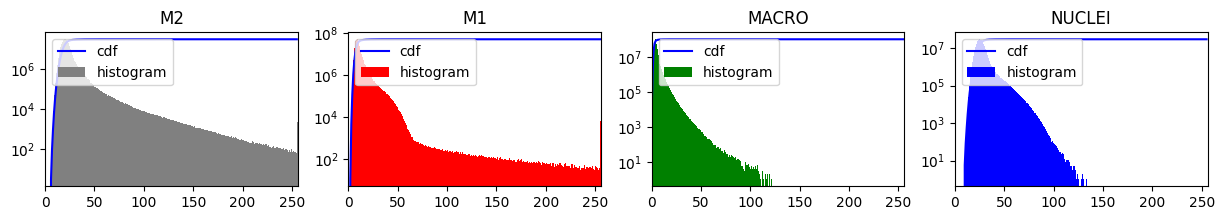

In [14]:
# Load and normalize image data for all channels
im_in=im_final_stack['Original image'].copy()
im_out = ((im_in - im_in.min()) / (im_in.max() - im_in.min()) * 255).clip(0, 255).astype('uint8')
im_final_stack['Normalized image']=im_out.copy()

# Plot histogram for each channel
hist_plot(im_final_stack['Normalized image'], stain_complete_df)

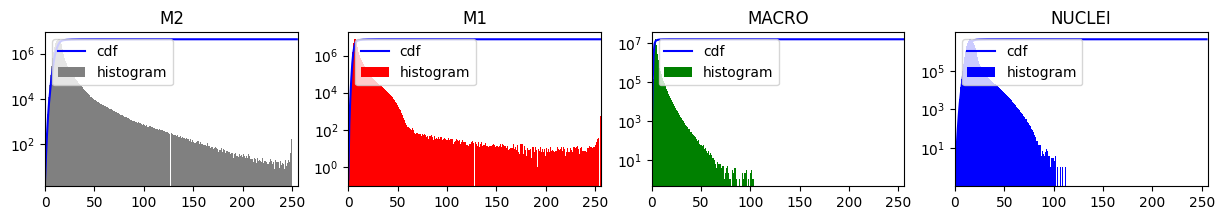

In [15]:
# Adapt resolution to isotropic
im_in=im_final_stack['Normalized image'].copy()

im_out = np.zeros((round(np.shape(im_in)[0] * (zoom_factors[0])),round(np.shape(im_in)[1] * (zoom_factors[1])),round(np.shape(im_in)[2] * (zoom_factors[2])),np.shape(im_in)[3]))

# Compute zoom factors to get isotropic spacing (same as Y and X)

# Resample image to isotropic spacing
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = zoom(im_in[:, :, :, c], zoom=zoom_factors, order=1)
    im_out[:, :, :, c] = im_out[:, :, :, c] - np.min(im_out[:, :, :, c])

im_out = ((im_out - im_out.min()) / (im_out.max() - im_out.min()) * 255).clip(0, 255).astype('uint8')
im_final_stack['Zoomed image']=im_out.copy()
hist_plot(im_final_stack['Zoomed image'], stain_complete_df)

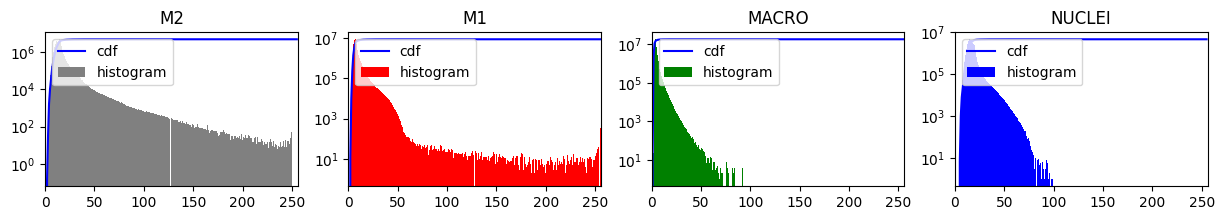

In [16]:
# Noise removal using median filter
im_in = im_final_stack['Zoomed image'].copy()
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = filters.median(im_in[:, :, :, c])
im_final_stack['Denoised image'] = im_out.copy()
hist_plot(im_final_stack['Denoised image'], stain_complete_df)

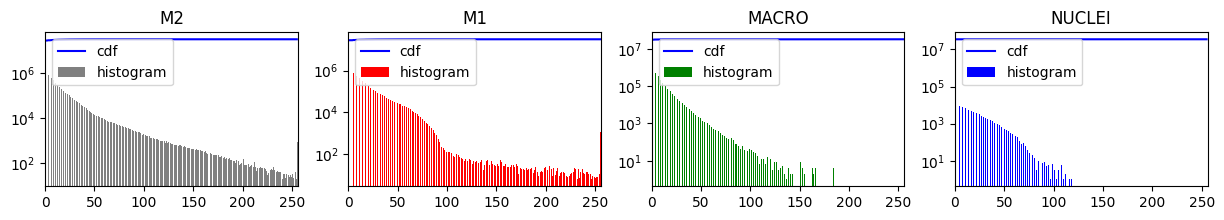

In [17]:
# Contrast and gamma adjustment for each channel
im_in = im_final_stack['Denoised image'].copy()
for c in range(im_in.shape[3]):
    idx = stain_complete_df.index[c]
    # im_out[:, :, :, c] = contr_stretch(im_in[:, :, :, c], stain_complete_df.loc[idx, 'Cont_min'], stain_complete_df.loc[idx, 'Cont_max'])
    # im_out[:, :, :, c] = gamma_trans(im_in[:, :, :, c], stain_complete_df.loc[idx, 'Gamma'])
    # im_out[:, :, :, c] = napari_gamma(im_in[:, :, :, c], stain_complete_df.loc[idx, 'Gamma'])
    im_out[:, :, :, c] = napari_contrast_gamma_uint8(im_in[:, :, :, c], (stain_complete_df.loc[idx, 'Cont_min'], stain_complete_df.loc[idx, 'Cont_max']), stain_complete_df.loc[idx, 'Gamma'])
im_final_stack['Adjusted image'] = im_out.copy()
hist_plot(im_final_stack['Adjusted image'], stain_complete_df)

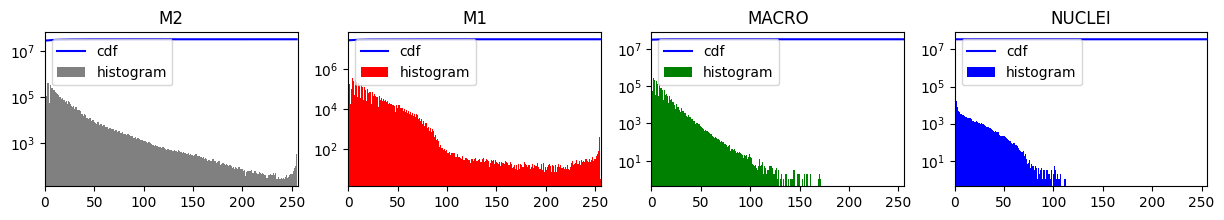

In [18]:
# Gaussian filter for smoothing
im_in = im_final_stack['Adjusted image'].copy()
for c in range(im_in.shape[3]):
    im_out[:, :, :, c] = filters.gaussian(im_in[:, :, :, c], 0.5, preserve_range=True)
im_final_stack['Filtered image'] = im_out.copy()
hist_plot(im_final_stack['Filtered image'], stain_complete_df)

In [19]:
# Export histograms
output_path=Path(input_file).stem + '_histograms.xlsx'
im_in = im_final_stack['Adjusted image'].copy()

with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
    for c in range(im_in.shape[3]):
        # Example input: 3D array (e.g. image stack)
        im3d = im_in[:, :, :, c].copy()

        # Compute histogram
        values, counts = np.unique(im3d.astype('int'), return_counts=True)
        hist = np.zeros(256, dtype=int)
        hist[values] = counts

        # Calculate totals, percentages, and cumulative values
        total = hist.sum()
        percentage = (hist / total) * 100
        cumulative = np.cumsum(hist)
        cumulative_percentage = np.cumsum(percentage)

        # Build DataFrame
        df = pd.DataFrame({
            "Pixel_Value": np.arange(256),
            "Count": hist,
            "Percentage": percentage,
            "Cumulative_Count": cumulative,
            "Cumulative_Percentage": cumulative_percentage
        })

        idx = stain_complete_df.index[c]
        marker = stain_complete_df.loc[idx, 'Marker']

        # Write each to a different sheet
        df.to_excel(writer, sheet_name=marker, index=False)
    
print(f"Saved to: {output_path}")

Saved to: EB-014_M2_ST_BX15043_20x_histograms.xlsx


In [20]:
# # Thresholding using Otsu, Sauvola, statistical background, gain filtering
# im_in = im_final_stack["Filtered image"].copy()
# im_out = im_in.copy()

# for c in range(im_in.shape[3]):
#     img = sitk.GetImageFromArray(im_in[:, :, :, c])

#     # Stretch for Otsu
#     rescaler = sitk.RescaleIntensityImageFilter()
#     rescaler.SetOutputMinimum(0)
#     rescaler.SetOutputMaximum(255)
#     stretched = rescaler.Execute(img)

#     # Otsu thresholds
#     th_filter = sitk.OtsuThresholdImageFilter()
#     _ = th_filter.Execute(stretched)
#     otsu_value = th_filter.GetThreshold()

#     _ = th_filter.Execute(img)
#     otsu_value2 = th_filter.GetThreshold()

#     # Sizes
#     nuclei_size = int(nuclei_diameter * scale_factor / (np.mean([r_X, r_Y])))
#     cell_size = int(cell_diameter * scale_factor / (np.mean([r_X, r_Y])))

#     if stain_complete_df.index[c] == "NUCLEI":
#         window_size = 2 * nuclei_size + 1
#     else:
#         window_size = 2 * cell_size + 1

#     # Convert to array
#     arr = sitk.GetArrayFromImage(img).astype(np.float32)

#     # Sauvola threshold map
#     sauvola_value = threshold_sauvola(arr, window_size=int(window_size))

#     # Statistical background threshold
#     hist, bins = np.histogram(arr, bins=256, range=(0, arr.max()))
#     mode_bin = bins[np.argmax(hist)]

#     bg_mask = (arr >= mode_bin - 5) & (arr <= mode_bin + 5)
#     bg_vals = arr[bg_mask]
#     if bg_vals.size < window_size:
#         bg_vals = arr

#     bg_mean = bg_vals.mean()
#     bg_std = bg_vals.std() + 1e-6
#     z = 3.0
#     statistical_thr = bg_mean + z * bg_std

#     print(bg_mean)

#     # Final combined threshold map
#     final_thr = (
#         0.75 * sauvola_value +
#         0.15 * statistical_thr +
#         0.10 * otsu_value2
#     )

#     # Extra improvement: intensity gain check
#     # Only keep pixels that rise at least X times above background mean
#     gain = arr / (bg_mean + 1e-6)
#     mask_gain = gain > 10.0    # adjust if needed

#     # Apply threshold
#     arrayseg = (arr > final_thr) & mask_gain

#     # Remove small islands
#     min_size = np.ceil(0.8 * np.pi * ((nuclei_size / 2) ** 2))
#     im_out[:, :, :, c] = remove_small_islands(arrayseg, min_size)

# im_final_stack["Threshold image"] = im_out.copy()

In [21]:
# Thresholding using Otsu, Sauvola, statistical background, gain filtering
im_in = im_final_stack["Filtered image"].copy()
im_out = im_in.copy()

for c in range(im_in.shape[3]):
    img = sitk.GetImageFromArray(im_in[:, :, :, c])

    # Stretch for Otsu
    rescaler = sitk.RescaleIntensityImageFilter()
    rescaler.SetOutputMinimum(0)
    rescaler.SetOutputMaximum(255)
    stretched = rescaler.Execute(img)

    if stain_complete_df.index[c] != 'NUCLEI':
        # Otsu thresholds
        th_filter = sitk.OtsuThresholdImageFilter()
        _ = th_filter.Execute(stretched)
        otsu_value = th_filter.GetThreshold()
    
        _ = th_filter.Execute(img)
        otsu_value2 = th_filter.GetThreshold()
    
        # Sizes
        nuclei_size = int(nuclei_diameter * scale_factor / (np.mean([r_X, r_Y])))
        cell_size = int(cell_diameter * scale_factor / (np.mean([r_X, r_Y])))
    
        if stain_complete_df.index[c] == "NUCLEI":
            window_size = 2 * nuclei_size + 1
        else:
            window_size = 4 * cell_size + 1
    
        # Convert to array
        arr = sitk.GetArrayFromImage(img).astype(np.float32)
    
        # Sauvola threshold map
        sauvola_value = threshold_sauvola(arr, window_size=int(window_size))
    
        # -------- GLOBAL statistical background, excluding zeros --------
        non_zero = arr[arr > 0]
    
        if non_zero.size > 0:
            hist, bins = np.histogram(non_zero, bins=256, range=(0, non_zero.max()))
            mode_bin = bins[np.argmax(hist)]
    
            bg_mask = (arr >= mode_bin - 5) & (arr <= mode_bin + 5) & (arr > 0)
            bg_vals = arr[bg_mask]
    
            if bg_vals.size < 50:
                p10 = np.percentile(non_zero, 10)
                bg_vals = non_zero[non_zero <= p10]
        else:
            bg_vals = arr
    
        bg_mean = bg_vals.mean()
        bg_std = bg_vals.std() + 1e-6
    
        bg_mean_z = arr.mean()
        bg_std_z = arr.std() + 1e-6
        z = 3.0
        statistical_thr = bg_mean_z + z * bg_std_z

        # ---------------------------------------------------------------
    
        # 1) Soften Sauvola if it is too aggressive for large/bright cells
        # Clip Sauvola so it cannot exceed a few std above the global (zero‑including) mean
        max_sauvola = bg_mean_z + 2.0 * bg_std_z
        sauvola_clipped = np.minimum(sauvola_value, max_sauvola)
    
        # Final combined threshold map (slightly less Sauvola weight)
        final_thr = (
            0.60 * sauvola_clipped +
            0.25 * statistical_thr +
            0.15 * otsu_value2
        )
    
        # Extra improvement: intensity gain check (global, using non-zero-based bg_mean)
        gain = arr / (bg_mean + 1e-6)
        mask_gain = gain > 4.0    # tune 2–5 depending on SNR
    
        # 2) Rescue pixels: strong gain but slightly under final_thr
        primary = (arr > final_thr) & mask_gain
        rescue = (gain > 6.0) & (arr > statistical_thr)   # gain threshold > primary, to keep it conservative
    
        arrayseg = primary | rescue

        min_size = np.ceil(0.8 * np.pi * ((nuclei_size / 2) ** 2))
    else:
        arr = sitk.GetArrayFromImage(img).astype(np.float32)
        arr_range = np.max(arr) - np.min(arr)
        arrayseg = arr>(np.min(arr)+0.1*arr_range)

        min_size=0.0

    # Remove small islands
    
    im_out[:, :, :, c] = remove_small_islands(arrayseg, min_size)

im_final_stack["Threshold image"] = im_out.copy()

In [22]:
# Segmentation of nuclei using watershed or StarDist
if 'NUCLEI' in stain_df.index:
    im_in=im_final_stack['Threshold image'].copy()
    
    for c in range(im_in.shape[3]):
        if stain_complete_df.index[c] == 'NUCLEI':
            if trig_stardist:
                im_in=im_final_stack['Filtered image'].copy()
                transl=stardist3d_from_2d(img_3d=im_in[:,:,:,c],nucleus_radius=nuclei_diameter*scale_factor/2.0,voxel_size=(r_Z, r_Y, r_X))
                im_mask = transl>0
                im_mask = morphology.binary_erosion(im_mask, footprint=np.ones((2, 2, 2))).astype(im_mask.dtype)
                im_out,num = label((transl * im_mask)>0)
            else:
                distance = ndi.distance_transform_edt(im_in[:, :, :, c],sampling=[r_Z,r_Y,r_X])
                radius_X = int((nuclei_diameter / 2) *scale_factor/ r_X)
                radius_Y = int((nuclei_diameter / 2) *scale_factor/ r_Y)
                radius_Z = int((nuclei_diameter / 2) *scale_factor/ r_Z)
                coords = peak_local_max(distance, footprint=make_anisotropic_footprint(radius_Z, radius_Y, radius_X), labels=im_in[:, :, :, c].astype(np.int32))
                mask = np.zeros(distance.shape, dtype=bool)
                mask[tuple(coords.T)] = True
                markers, _ = label(mask)
                im_out = watershed(-distance, markers, mask=im_in[:, :, :, c])
                #im_out = merge_touching_labels(im_out)
                size_nuclei=np.pi*4.0*(np.mean([radius_X,radius_Y])**3.0)/3.0
                #print(size_nuclei)
                im_out=merge_small_touching_labels(im_out,size_nuclei,z_weight=r_Z/r_X)
                
            im_segmentation_stack={'Nuclei': im_out}
            
            cm_rand = np.random.rand(int(np.max(im_segmentation_stack['Nuclei'])), 3)
            cm_rand[0, :] = [0.0, 0.0, 0.0]
            colormaps_rand = Colormap(cm_rand)

In [23]:
# Segmentation of cytoplasm
im_in=im_final_stack['Threshold image'].copy()

if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    im_out = np.zeros_like(im_in[:,:,:,0], dtype=np.int32)
    
    for c in range(im_in.shape[3]):
        if stain_complete_df.index[c] == 'CYTOPLASM':
            distance = ndi.distance_transform_edt(im_in[:, :, :, c],sampling=[r_Z,r_Y,r_X])
            radius_X = int((nuclei_diameter / 2) *scale_factor/ r_X)
            radius_Y = int((nuclei_diameter / 2) *scale_factor/ r_Y)
            radius_Z = int((nuclei_diameter / 2) *scale_factor/ r_Z)
            coords = peak_local_max(distance, footprint=make_anisotropic_footprint(radius_Z, radius_Y, radius_X), labels=im_in[:, :, :, c].astype(np.int32))
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = label(mask)
            im_out = watershed(-distance, im_segmentation_stack['Nuclei'], mask=im_in[:, :, :, c])
    
    if 'CYTOPLASM' not in stain_df.index:
        im_out=grow_labels(im_segmentation_stack['Nuclei'], cyto_factor)
        #stain_df.loc['CYTOPLASM']=['', '', '']
        stain_complete_df.loc['CYTOPLASM']=['', '', '', '', '', '']
        
    im_segmentation_stack['Cytoplasm'] = im_out.copy()

In [24]:
# Segmentation of the pericellular matrix (PCM)
im_in=im_final_stack['Threshold image'].copy()

if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    im_out = np.zeros_like(im_in[:,:,:,0], dtype=np.int32)
    
    im_out=grow_labels(im_segmentation_stack['Nuclei'], PCM_factor)
    im_out=im_out-im_segmentation_stack['Cytoplasm']
        
    im_segmentation_stack['PCM'] = im_out.copy()

In [25]:
# Assign segmented nuclei labels to other channels (cell assignment)
im_in=im_final_stack['Threshold image'].copy()

if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
    for c in range(im_in.shape[3]):
        if (stain_df.index[c] != 'NUCLEI') & (stain_df.index[c] != 'CYTOPLASM') & (stain_df.index[c] != 'PCM'):
            im_segmentation_stack[stain_df.index[c]] = im_in[:, :, :, c] * (im_segmentation_stack['Cytoplasm'] + im_segmentation_stack['PCM'])

In [26]:
# # Evaluate aggregates
# if ('NUCLEI' in stain_df.index)|('CYTOPLASM' in stain_df.index):
#     im_out,num_aggregates=label(grow_labels(im_segmentation_stack['Cytoplasm'],2.0)>0)
#     im_segmentation_stack['Aggregates']=im_out*(im_segmentation_stack['Cytoplasm']>0)

In [27]:
# Visualize original, denoised, filtered, corrected, thresholded, assigned, and segmented images
viewer_0 = napari.Viewer()
scale_zoom=(r_Z/zoom_factors[2], r_Y/zoom_factors[1], r_X/zoom_factors[0])

for c in range(im_in.shape[3]):
    idx = stain_complete_df.index[c]
    marker = stain_complete_df.loc[idx, 'Marker']
    color = stain_complete_df['Color'].iloc[c]
    #viewer_0.add_image(im_final_stack['Normalized image'], name=f'NORMALIZED {idx} ({marker})', colormap=color, blending='additive')
    viewer_0.add_image(im_final_stack['Zoomed image'][:, :, :, c], name=f'ORIGINAL {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Denoised image'][:, :, :, c], name=f'DENOISED {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Adjusted image'][:, :, :, c], name=f'CORRECTED {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Filtered image'][:, :, :, c], name=f'FILTERED {idx} ({marker})', colormap=color, blending='additive', scale=scale_zoom)
    viewer_0.add_image(im_final_stack['Threshold image'][:, :, :, c].astype('uint8'), name=f'THRESHOLD {idx} ({marker})', contrast_limits=[0, 1], colormap=color, blending='additive', scale=scale_zoom)    
viewer_0.scale_bar.visible = True
viewer_0.scale_bar.unit = 'um'

if ('NUCLEI' in stain_complete_df.index)|('CYTOPLASM' in stain_complete_df.index):
    viewer_1 = napari.Viewer()

    im_in=im_final_stack['Threshold image'].copy()
    
    for c in range(len(stain_complete_df.index)):
        idx = stain_complete_df.index[c]
        marker = stain_complete_df.loc[idx, 'Marker']
        if stain_complete_df.index[c] == 'NUCLEI':
            viewer_1.add_labels(im_segmentation_stack['Nuclei'].astype('uint8'), name=f'{idx} ({marker})', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
        if stain_complete_df.index[c] == 'CYTOPLASM':
            viewer_1.add_labels(im_segmentation_stack['Cytoplasm'].astype('uint8'), blending='additive', name=f'{idx} ({marker})', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
            viewer_1.add_labels(im_segmentation_stack['PCM'].astype('uint8'), name=f'PCM', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
            #viewer_1.add_labels(im_segmentation_stack['Aggregates'].astype('uint8'), name=f'AGGREGTES', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_aggregates)], blending='additive')
        if (stain_complete_df.index[c] != 'NUCLEI') & (stain_complete_df.index[c] != 'CYTOPLASM') & (stain_complete_df.index[c] != 'PCM'):
            viewer_1.add_labels(im_segmentation_stack[stain_df.index[c]].astype('uint8'), name=f'{idx} ({marker})', blending='additive', scale=scale_zoom) #, colormap=colormaps_rand, contrast_limits=[0, np.max(im_nuclei_segmented)], blending='additive')
    viewer_1.scale_bar.visible = True
    viewer_1.scale_bar.unit = 'um'

## QUANTIFICATION

# 6. Quantification and Analysis

This section quantifies nuclei and cell properties, computes statistics, and visualizes distributions. Results are exported for further analysis.

In [33]:
labels_dict = {}

r_xyz = (r_X, r_Y, r_Z)
zooms = zoom_factors
nuc_positions, nuc_sizes, cyto_positions, cyto_sizes = compute_nuclei_cytoplasm_stats(im_segmentation_stack, r_xyz, zooms)

c_nuc = None
c_cyto = None

if 'NUCLEI' in stain_complete_df.index:
    c_nuc = stain_complete_df.index.get_loc('NUCLEI')
if 'CYTOPLASM' in stain_complete_df.index:
    c_cyto = stain_complete_df.index.get_loc('CYTOPLASM')

if c_nuc is not None:
    nuc_marker = stain_complete_df['Marker'][c_nuc]
    labels_dict[nuc_marker] = [
        stain_complete_df.index[c_nuc],
        stain_complete_df['Laser'][c_nuc],
        stain_complete_df['Color'][c_nuc],
        int(np.max(im_segmentation_stack['Nuclei'])),
        (),  # Shared labels placeholder
        tuple(nuc_positions),
        (),
        tuple(nuc_sizes),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        ()
    ]

if c_cyto is not None:
    cyto_marker = stain_complete_df['Marker'][c_cyto]
    labels_dict[cyto_marker] = [
        stain_complete_df.index[c_cyto],
        stain_complete_df['Laser'][c_cyto],
        stain_complete_df['Color'][c_cyto],
        int(np.max(im_segmentation_stack['Cytoplasm'])),
        (),
        (),
        tuple(cyto_positions),
        (),
        tuple(cyto_sizes),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        (),
        ()
    ]

filtered_img = im_final_stack['Filtered image']
num_channels = filtered_img.shape[3]

for c in range(num_channels):
    condition = stain_complete_df.index[c]
    if condition in ['NUCLEI', 'CYTOPLASM', 'PCM']:
        continue
    marker = stain_complete_df['Marker'][c]

    shared_labels, m_sizes, m_avg, m_std, m_cyto_sizes, m_cyto_avg, m_cyto_std, m_pcm_sizes, m_pcm_avg, m_pcm_std = compute_marker_stats_for_marker(c, im_segmentation_stack, filtered_img, r_xyz, zooms)

    labels_dict[marker] = [
        condition,
        stain_complete_df['Laser'][c],
        stain_complete_df['Color'][c],
        len(shared_labels),
        tuple(sorted(shared_labels)),
        tuple(nuc_positions[i-1] for i in shared_labels) if len(shared_labels)>0 else (),
        tuple(cyto_positions[i-1] for i in shared_labels) if len(shared_labels)>0 else (),
        tuple(nuc_sizes[i-1] for i in shared_labels) if len(shared_labels)>0 else (),
        tuple(cyto_sizes[i-1] for i in shared_labels) if len(shared_labels)>0 else (),
        tuple(m_sizes),
        tuple(m_avg),
        tuple(m_std),
        tuple(m_cyto_sizes),
        tuple(m_cyto_avg),
        tuple(m_cyto_std),
        tuple(m_pcm_sizes),
        tuple(m_pcm_avg),
        tuple(m_pcm_std)
    ]

    # list_ints = [np.round(x) for x in list_m]
    # hist, _ = np.histogram(np.concatenate(list_ints), 256, [0, 256])
    # axs[c].hist(np.concatenate(list_ints), 256, [0, 256], color=stain_complete_df['Color'][c] if stain_complete_df['Color'][c] != 'WHITE' else 'GRAY')
    # axs[c].set_xlim([0, 256])
    # axs[c].legend(('cdf', 'histogram'), loc='upper left')
    # axs[c].set_title(stain_complete_df.index[c])
    

if multilabel:
    max_combo_size = min(3, max(2, num_channels - 1))
    non_nuc_channels = [i for i in range(num_channels) if stain_complete_df.index[i] not in ['NUCLEI', 'CYTOPLASM', 'PCM']]
    
    marker_index_to_shared = {}
    for c in non_nuc_channels:
        mname = stain_complete_df['Marker'][c]
        marker_index_to_shared[c] = set(labels_dict[mname][4]) if mname in labels_dict else set()
    
    for k in range(2, max_combo_size + 1):
        for comb in combinations(non_nuc_channels, k):
            combo_markers = tuple(stain_complete_df['Marker'][i] for i in comb)
            # intersect shared label sets
            sets = [marker_index_to_shared[i] for i in comb]
            if len(sets) == 0:
                continue
            combo_labels = set.intersection(*sets)
            combo_labels = sorted(combo_labels)
            if len(combo_labels) == 0:
                continue
            # build entry similar to single markers
            labels_dict[tuple(combo_markers)] = [
                tuple(stain_complete_df.index[i] for i in comb),
                (),
                (),
                len(combo_labels),
                tuple(combo_labels),
                tuple(nuc_positions[i-1] for i in combo_labels) if len(combo_labels)>0 else (),
                tuple(cyto_positions[i-1] for i in combo_labels) if len(combo_labels)>0 else (),
                tuple(nuc_sizes[i-1] for i in combo_labels) if len(combo_labels)>0 else (),
                tuple(cyto_sizes[i-1] for i in combo_labels) if len(combo_labels)>0 else (),
                (),
                (),
                (),
                (),
                (),
                (),
                (),
                (),
                ()
            ]

In [34]:
# Create DataFrame for quantification results and truncate long values for display
labels_df = pd.DataFrame.from_dict(labels_dict, orient='index', columns=['Condition', 'Laser', 'Color', 'Number', 'Shared labels', 'Mean nuclei positions [um]', 'Mean cytoplasm positions [um]', 'Nuclei size [um3]', 'Cytoplasm size [um3]', 'Marker size [um3]', 'Avg. marker intensity', 'STD marker intensity', 'Marker size cytoplasm [um3]', 'Avg. marker intensity cytoplasm', 'STD marker intensity cytoplasm', 'Marker size PCM [um3]', 'Avg. marker intensity PCM', 'STD marker intensity PCM'])
labels_df.index.name = 'Combination'
truncated_df = labels_df.copy()
for col in ["Shared labels", "Mean nuclei positions [um]", "Mean cytoplasm positions [um]", "Nuclei size [um3]", "Cytoplasm size [um3]", 'Marker size [um3]', 'Avg. marker intensity', 'STD marker intensity', 'Marker size cytoplasm [um3]', 'Avg. marker intensity cytoplasm', 'STD marker intensity cytoplasm', 'Marker size PCM [um3]', 'Avg. marker intensity PCM', 'STD marker intensity PCM']:
    truncated_df[col] = truncated_df[col].apply(lambda x: truncate_cell(x))

In [35]:
# Display quantification DataFrame
labels_df

,Condition,Laser,Color,Number,Shared labels,Mean nuclei positions [um],Mean cytoplasm positions [um],Nuclei size [um3],Cytoplasm size [um3],Marker size [um3],Avg. marker intensity,STD marker intensity,Marker size cytoplasm [um3],Avg. marker intensity cytoplasm,STD marker intensity cytoplasm,Marker size PCM [um3],Avg. marker intensity PCM,STD marker intensity PCM
Combination,,,,,,,,,,,,,,,,,,
DAPI,NUCLEI,DAPI_20X,BLUE,363,(),"((139.52047127241022, 996.4689712252214, 3.256...",(),"(80.64697000931635, 55.88693535733326, 236.988...",(),(),(),(),(),(),(),(),(),()
,CYTOPLASM,,,363,(),(),"((139.52340115125875, 996.4562361383246, 4.935...",(),"(459.121785403915, 374.23023802568724, 926.025...",(),(),(),(),(),(),(),(),()
CD206,M2,647_20X,WHITE,143,"(1, 3, 4, 7, 10, 14, 15, 18, 19, 20, 27, 32, 3...","((139.52047127241022, 996.4689712252214, 3.256...","((139.52340115125875, 996.4562361383246, 4.935...","(80.64697000931635, 236.9889030975524, 109.651...","(459.121785403915, 926.0252959841673, 557.4544...","(4.952006930396617, 236.9889030975524, 41.0309...","(23.0, 57.89850746268657, 24.482758620689655, ...","(0.0, 7.75608557482279, 1.4292677086939798, 10...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
INOS,M1,568_20X,RED,171,"(1, 2, 3, 4, 7, 8, 9, 11, 14, 15, 16, 18, 19, ...","((139.52047127241022, 996.4689712252214, 3.256...","((139.52340115125875, 996.4562361383246, 4.935...","(80.64697000931635, 55.88693535733326, 236.988...","(459.121785403915, 374.23023802568724, 926.025...","(80.64697000931633, 54.47207623436279, 236.988...","(38.08771929824562, 24.77922077922078, 42.4388...","(2.5634454730179748, 2.3445065751937366, 4.300...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
F4_80,MACRO,488_20X,GREEN,63,"(1, 9, 11, 13, 15, 18, 19, 20, 37, 38, 39, 40,...","((139.52047127241022, 996.4689712252214, 3.256...","((139.52340115125875, 996.4562361383246, 4.935...","(80.64697000931635, 110.35901159169606, 124.50...","(459.121785403915, 542.5984736591721, 574.4328...","(72.15781527149358, 26.17489377495355, 6.36686...","(18.794117647058822, 16.27027027027027, 14.777...","(3.3057829166540142, 1.7956200261484423, 1.314...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(CD206, INOS)","(M2, M1)",(),(),107,"(1, 3, 4, 7, 14, 15, 18, 19, 20, 32, 38, 40, 4...","((139.52047127241022, 996.4689712252214, 3.256...","((139.52340115125875, 996.4562361383246, 4.935...","(80.64697000931635, 236.9889030975524, 109.651...","(459.121785403915, 926.0252959841673, 557.4544...",(),(),(),(),(),(),(),(),()
"(CD206, F4_80)","(M2, MACRO)",(),(),43,"(1, 15, 18, 19, 20, 38, 40, 41, 43, 52, 76, 77...","((139.52047127241022, 996.4689712252214, 3.256...","((139.52340115125875, 996.4562361383246, 4.935...","(80.64697000931635, 544.7207623436278, 304.902...","(459.121785403915, 1673.0709129125714, 1143.20...",(),(),(),(),(),(),(),(),()
"(INOS, F4_80)","(M1, MACRO)",(),(),47,"(1, 9, 11, 15, 18, 19, 20, 37, 38, 39, 40, 41,...","((139.52047127241022, 996.4689712252214, 3.256...","((139.52340115125875, 996.4562361383246, 4.935...","(80.64697000931635, 110.35901159169606, 124.50...","(459.121785403915, 542.5984736591721, 574.4328...",(),(),(),(),(),(),(),(),()
"(CD206, INOS, F4_80)","(M2, M1, MACR

In [36]:
# Print summary statistics for nuclei and cell populations
print('TOT CELLS =', labels_df['Number'][stain_complete_df['Marker']['NUCLEI']])
print(" ")
for i, marker in enumerate(labels_df.index):
    if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (labels_df['Condition'][i] != 'NUCLEI + CYTOPLASM'):
        print(f" PERC {labels_df['Condition'][i]} ({marker}) = {100.0 * labels_df['Number'][i] / labels_df['Number'][0]} %")
print('_' * 80)
print('MEAN SIZE NUCLEI =', np.mean(labels_df['Nuclei size [um3]'][stain_complete_df['Marker']['NUCLEI']]), 'um3')
if 'CYTOPLASM' in stain_df.index:
    print('MEAN SIZE CYTOPLASM =', np.mean(labels_df['Cytoplasm size [um3]'][stain_complete_df['Marker']['CYTOPLASM']]), 'um3')
for i, marker in enumerate(labels_df.index):
    if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (labels_df['Condition'][i] != 'NUCLEI + CYTOPLASM'):
        print(" ")
        print(f" MEAN SIZE NUCLEI {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Nuclei size [um3]'][i])} um3")
        if 'CYTOPLASM' in stain_df.index:
            print(f" MEAN SIZE CYTOPLASM {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Cytoplasm size [um3]'][i])} um3")
print('_' * 80)
for i, marker in enumerate(labels_df.index):
    if (labels_df['Marker size [um3]'][i]!=()):
        print(f"MEAN SIZE {labels_df['Condition'][i]} ({marker}) = {np.mean(labels_df['Marker size [um3]'][i])} um3")

TOT CELLS = 363
 
 PERC M2 (CD206) = 39.39393939393939 %
 PERC M1 (INOS) = 47.107438016528924 %
 PERC MACRO (F4_80) = 17.355371900826448 %
 PERC ('M2', 'M1') (('CD206', 'INOS')) = 29.47658402203857 %
 PERC ('M2', 'MACRO') (('CD206', 'F4_80')) = 11.845730027548209 %
 PERC ('M1', 'MACRO') (('INOS', 'F4_80')) = 12.947658402203857 %
 PERC ('M2', 'M1', 'MACRO') (('CD206', 'INOS', 'F4_80')) = 10.192837465564738 %
________________________________________________________________________________
MEAN SIZE NUCLEI = 71.31201794453877 um3
 
 MEAN SIZE NUCLEI M2 (CD206) = 113.57460050753801 um3
 
 MEAN SIZE NUCLEI M1 (INOS) = 107.30589453686505 um3
 
 MEAN SIZE NUCLEI MACRO (F4_80) = 133.54698055148972 um3
 
 MEAN SIZE NUCLEI ('M2', 'M1') (('CD206', 'INOS')) = 129.6050625588316 um3
 
 MEAN SIZE NUCLEI ('M2', 'MACRO') (('CD206', 'F4_80')) = 164.53495452125105 um3
 
 MEAN SIZE NUCLEI ('M1', 'MACRO') (('INOS', 'F4_80')) = 165.8094478579001 um3
 
 MEAN SIZE NUCLEI ('M2', 'M1', 'MACRO') (('CD206', 'INOS

### HISTOGRAMS

In [43]:
hist_data = {}
# Store original intensity ranges for PDF output
intensity_ranges = {}

for c in range(im_in.shape[3]):
    if stain_df.index[c] != 'NUCLEI':

        idx = c
        seg_stack = im_segmentation_stack
        
        condition = stain_complete_df.index[idx]
        marker_name = stain_complete_df['Marker'][idx]

        seg_key = stain_df.index[idx]

        marker_img = seg_stack.get(seg_key, None)
        marker_img_cyto = seg_stack.get(seg_key + '_cyto', None)
        marker_img_pcm = seg_stack.get(seg_key + '_PCM', None)
        
        max_n = int(np.max(seg_stack['Nuclei']))

        # Find channel index in filtered_img
        ch_idx = None
        for i, cond in enumerate(stain_complete_df.index):
            if cond == condition:
                ch_idx = i
                break

        # Store original min/max from filtered image for this channel
        if ch_idx is not None:
            intensity_ranges[condition] = (
                float(filtered_img[:, :, :, ch_idx].min()),
                float(filtered_img[:, :, :, ch_idx].max())
            )

        for n in range(1, max_n + 1):

            if n not in hist_data:
                hist_data[n] = {}  # add nucleus
            if condition not in hist_data[n]:
                hist_data[n][condition] = []  # add condition for that nucleus

            nuc_mask = (seg_stack['Nuclei'] == n)
            mask_marker_in_nucleus = (marker_img > 0) & nuc_mask

            if np.any(mask_marker_in_nucleus):
                vox = np.where(mask_marker_in_nucleus)
                if ch_idx is not None:
                    vals = filtered_img[vox[0], vox[1], vox[2], ch_idx]
                    if vals.size > 0:
                        hist_data[n][condition].extend(vals.tolist())

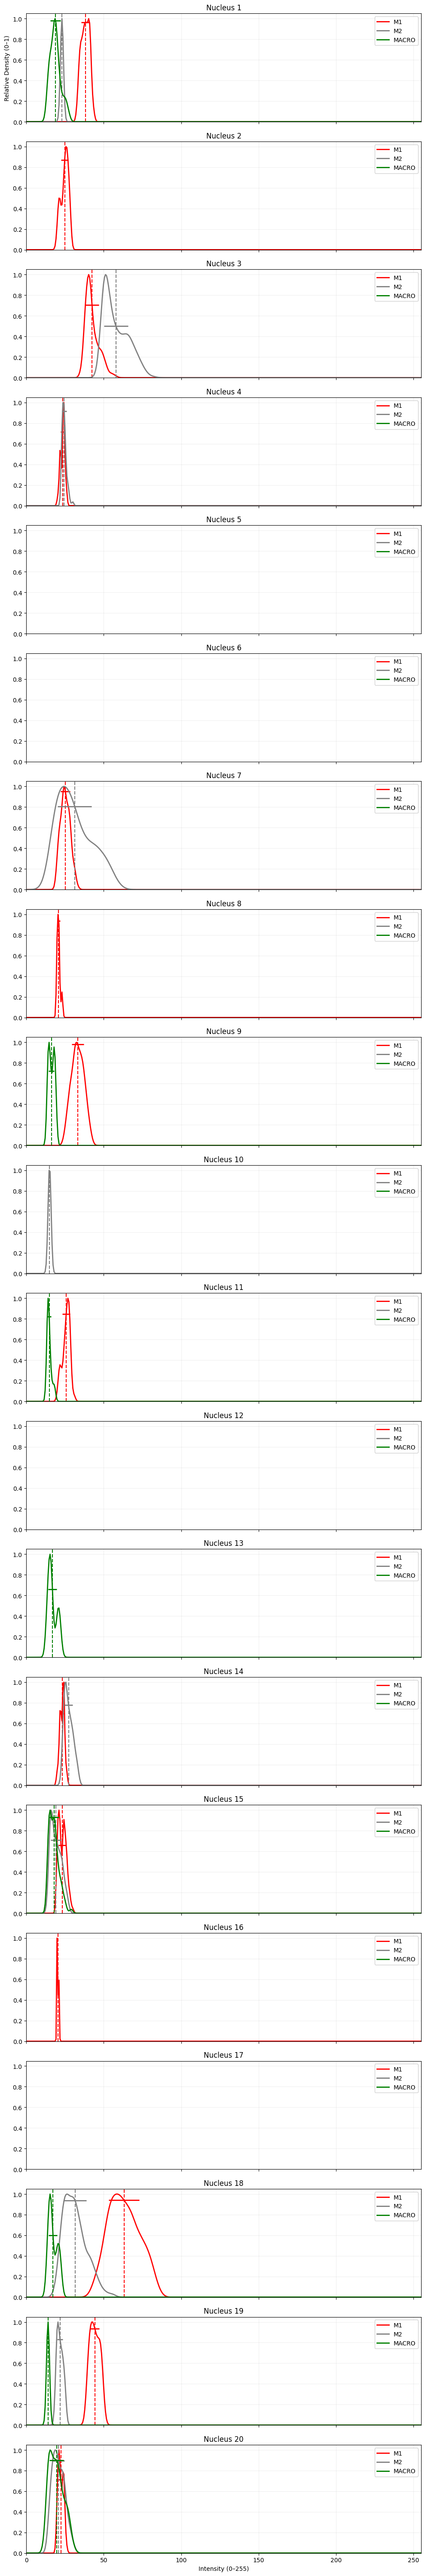

In [44]:
# --- REQUIRE: hist_data must exist in the form hist_data[n][condition] = list(values) ---
# e.g. hist_data = {1: {'MACRO': [...], 'CD3': [...], 'CD20': [...]}, 2: {...}, ...}

# Derive nuclei and condition list from hist_data
nuclei = sorted(hist_data.keys())
if len(nuclei) == 0:
    raise ValueError("hist_data is empty. Fill hist_data before plotting.")

max_n = max(nuclei)
all_conditions = sorted({cond for ndata in hist_data.values() for cond in ndata.keys()})

# Assign consistent colors per condition
color_cycle = plt.cm.tab10
condition_colors = {cond: color_cycle(i % 10) for i, cond in enumerate(all_conditions)}

# Limit figure size to prevent matplotlib rendering errors
max_subplots = min(max_n, 20)  # Cap at 20 subplots
height = min(3 * max_subplots, 60)  # Cap height at 60 inches

# Prepare multi-row figure (one subplot per nucleus)
fig, axes = plt.subplots(max_subplots, 1, figsize=(10, height), sharex=True)
if max_subplots == 1:
    axes = [axes]

x_grid = np.linspace(0, 255, 400)

# Only plot nuclei that fit in the subplot grid
nuclei_to_plot = nuclei[:max_subplots]

for idx, n in enumerate(nuclei_to_plot):
    ax = axes[idx]  # Use subplot index instead of nucleus number
    ax.set_title(f"Nucleus {n}")
    ax.set_xlim(0, 255)
    ax.set_ylim(0, 1.05)
    ax.grid(alpha=0.2)

    # For each condition, plot density if data exists
    for cond in all_conditions:
        vals = np.array(hist_data.get(n, {}).get(cond, []))
        if stain_complete_df['Color'][cond] != 'WHITE':
            color = stain_complete_df['Color'][cond]  
        else:
            color = 'GRAY'

        if vals.size == 0:
            # no data for this nucleus & condition: skip curve plotting
            continue

        # try KDE, fallback if singular
        y_grid = None
        try:
            kde = gaussian_kde(vals)
            y_grid = kde(x_grid)
        except Exception:
            # fallback: create a narrow Gaussian around the mean (handles zero-variance)
            mean_val = vals.mean()
            bw = 1.0  # small bandwidth fallback
            y_grid = np.exp(-0.5 * ((x_grid - mean_val) / bw) ** 2)
        
        # normalize y to 0-1
        if y_grid.max() > 0:
            y_norm = y_grid / y_grid.max()
        else:
            y_norm = y_grid

        # plot density curve
        ax.plot(x_grid, y_norm, linewidth=2, color=color)

        # compute mean and std from raw vals
        mean_val = float(vals.mean())
        std_val = float(vals.std())

        # vertical mean line (same color)
        ax.axvline(mean_val, linestyle='--', linewidth=1.5, color=color)

        # y position for std-line: read normalized KDE at mean (interpolate)
        y_at_mean = np.interp(mean_val, x_grid, y_norm)

        # horizontal std line from mean-std to mean+std (clamped to axis)
        x_start = max(0.0, mean_val - std_val)
        x_end = min(255.0, mean_val + std_val)
        ax.hlines(y_at_mean, x_start, x_end, linewidth=2, color=color)

    # Build a legend showing all conditions with their assigned color (consistent across plots)
    legend_handles = [Line2D([0], [0], color=stain_complete_df['Color'][c] if stain_complete_df['Color'][c] != 'WHITE' else 'GRAY', lw=2) for c in all_conditions]
    ax.legend(legend_handles, all_conditions, loc='upper right', framealpha=0.9)

    if n == nuclei_to_plot[-1]:
        ax.set_xlabel("Intensity (0–255)")

axes[0].set_ylabel("Relative Density (0–1)")
plt.tight_layout()
plt.show()

In [45]:
# Full block: one nucleus per page, 3 channel crops + merged in one horizontal row
styles = getSampleStyleSheet()

create_row_pdf(
    output_pdf=Path(input_file).stem + "_nuclei_marker.pdf",
    pad=20,
    thumb_size=(2.0 * inch, 2.0 * inch)
)

PDF saved to: EB-014_M2_ST_BX15043_20x_nuclei_marker.pdf


## Evaluate cell distribution in the space

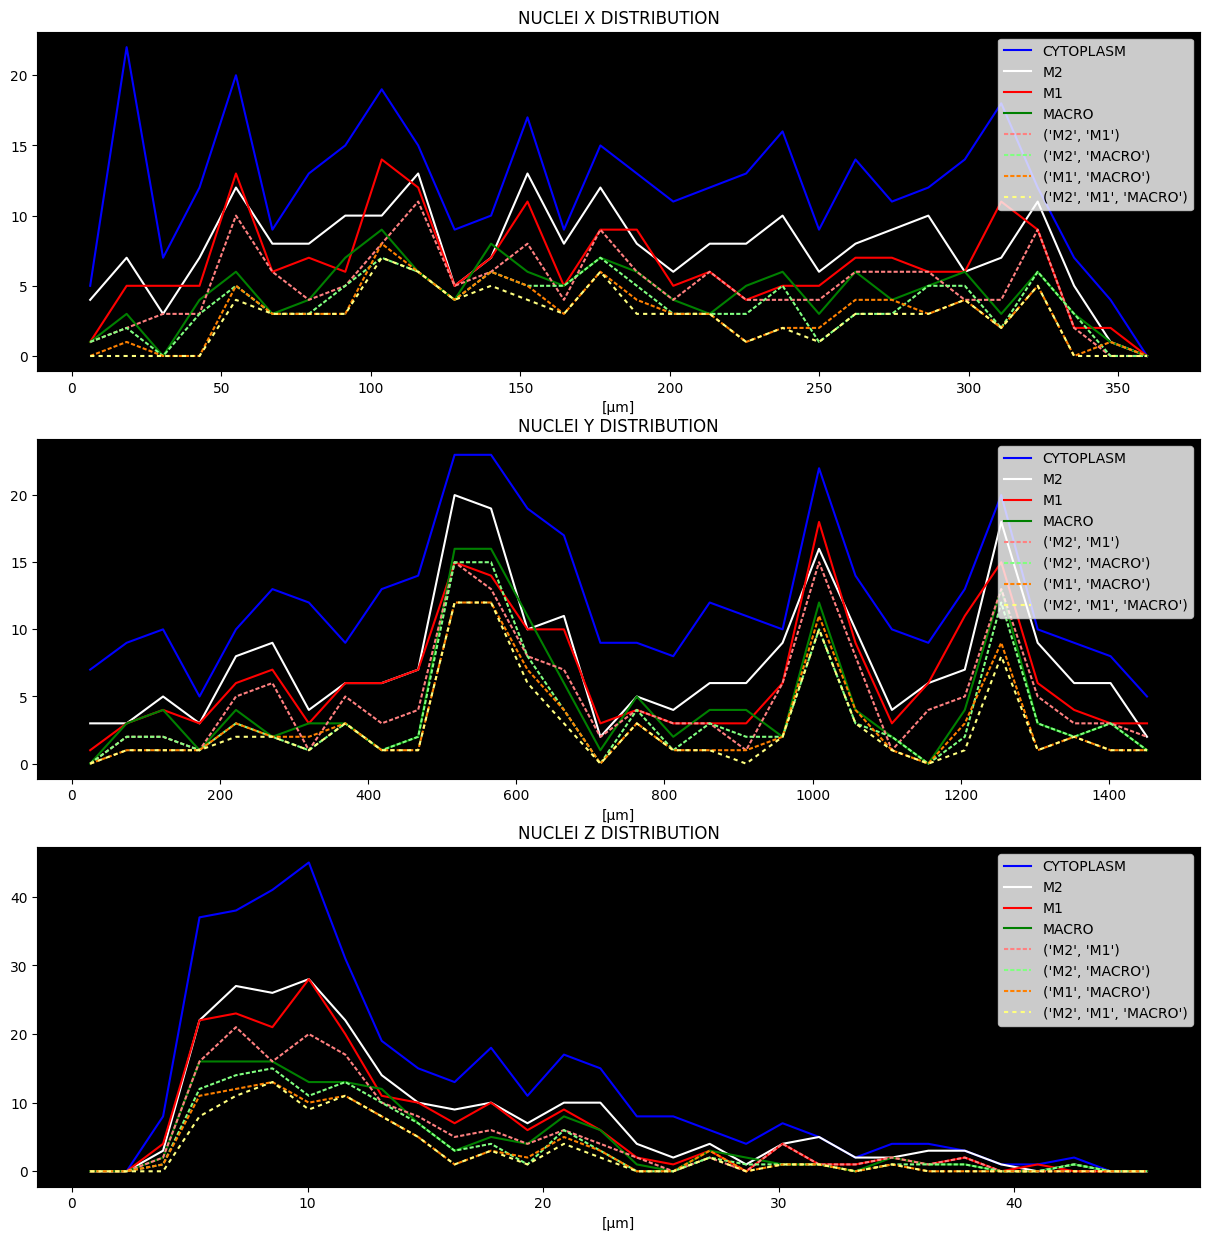

In [34]:
# Plot spatial distribution of nuclei and cells
im_in=im_final_stack['Filtered image']

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for i, marker in enumerate(labels_df.index):   
    xcoor = [t[0] for t in labels_df['Mean cytoplasm positions [um]'][i]]
    ycoor = [t[1] for t in labels_df['Mean cytoplasm positions [um]'][i]]
    zcoor = [t[2] for t in labels_df['Mean cytoplasm positions [um]'][i]] 
    xcount, xbins = np.histogram(xcoor, range=(0, im_in.shape[2] * r_X /zoom_factors[2]), bins=30)
    ycount, ybins = np.histogram(ycoor, range=(0, im_in.shape[1] * r_Y /zoom_factors[1]), bins=30)
    zcount, zbins = np.histogram(zcoor, range=(0, im_in.shape[0] * r_Z /zoom_factors[0]), bins=30)
    xbin_centers = (xbins[:-1] + xbins[1:]) / 2
    ybin_centers = (ybins[:-1] + ybins[1:]) / 2
    zbin_centers = (zbins[:-1] + zbins[1:]) / 2
    if (np.size(marker)==1):
        color = stain_complete_df.loc[str(labels_df['Condition'][i])]['Color']
        if color == '':
            color='BLUE'
        if (labels_df['Condition'][i]!='NUCLEI'):
            axs[0].plot(xbin_centers,xcount,label=str(labels_df['Condition'][i]),color=color)
            axs[1].plot(ybin_centers,ycount,label=str(labels_df['Condition'][i]),color=color)
            axs[2].plot(zbin_centers,zcount,label=str(labels_df['Condition'][i]),color=color)
    else:
        rgb_list=[]
        for k in range(np.size(marker)):
            if stain_df.loc[(labels_df['Condition'][i][k])]['Color']!='WHITE':
                rgb_list.append(stain_complete_df.loc[(labels_df['Condition'][i][k])]['Color'])
            else:
                rgb_list.append('GRAY')

        colors_rgb = [to_rgb(name) for name in rgb_list]

        r_total, g_total, b_total = 0.0, 0.0, 0.0

        for r, g, b in colors_rgb:
            r_total += r
            g_total += g
            b_total += b
        
        r_final = min(r_total, 1.0)
        g_final = min(g_total, 1.0)
        b_final = min(b_total, 1.0)
    
        final_rgb = (r_final, g_final, b_final)
        
        axs[0].plot(xbin_centers,xcount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        axs[1].plot(ybin_centers,ycount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        axs[2].plot(zbin_centers,zcount,label=str(labels_df['Condition'][i]),linestyle=(0, (2, np.size(marker)-1)), color=final_rgb)
        
axs[0].set_title('NUCLEI X DISTRIBUTION')
axs[0].set_xlabel('[μm]')
axs[0].legend(loc='upper right')
axs[0].set_facecolor('black')
axs[1].set_title('NUCLEI Y DISTRIBUTION')
axs[1].set_xlabel('[μm]')
axs[1].legend(loc='upper right')
axs[1].set_facecolor('black')
axs[2].set_title('NUCLEI Z DISTRIBUTION')
axs[2].set_xlabel('[μm]')
axs[2].legend(loc='upper right')
axs[2].set_facecolor('black')

## Evaluate cell size distribution

In [ ]:
# Plot size distribution of nuclei and cells
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
nuclei_max_size = max(x for t in labels_df['Nuclei size [um3]'] for x in t)
cytoplasm_max_size = max(x for t in labels_df['Cytoplasm size [um3]'] for x in t)
for i, marker in enumerate(labels_df.index):
    nuclei_sizes = list(labels_df['Nuclei size [um3]'][i])
    cell_sizes = list(labels_df['Cytoplasm size [um3]'][i])
    if np.size(marker)==1:
        if stain_df.loc[(labels_df['Condition'][i])]['Color']=='':
            color = 'BLUE'
        else:
            if stain_df.loc[(labels_df['Condition'][i])]['Color']!='WHITE':
                color = stain_df.loc[str(labels_df['Condition'][i])]['Color']
            else:
                color = 'GRAY'
        #color = stain_df.loc[str(labels_df['Condition'][i])]['Color']
        #axs[0].hist(nuclei_sizes, range=(0, nuclei_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/len(labels_df), color=color)
    else:
        rgb_list=[]
        for k in range(np.size(marker)):
            if stain_df.loc[(labels_df['Condition'][i][k])]['Color']!='WHITE':
                rgb_list.append(stain_df.loc[(labels_df['Condition'][i][k])]['Color'])
            else:
                rgb_list.append('GRAY')

        colors_rgb = [to_rgb(name) for name in rgb_list]

        r_total, g_total, b_total = 0.0, 0.0, 0.0

        for r, g, b in colors_rgb:
            r_total += r
            g_total += g
            b_total += b
        
        r_final = min(r_total, 1.0)
        g_final = min(g_total, 1.0)
        b_final = min(b_total, 1.0)
    
        color = (r_final, g_final, b_final)
        
    if labels_df['Condition'][i] != 'CYTOPLASM':    
        axs[0].hist(nuclei_sizes, range=(0, nuclei_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/len(labels_df), color=color)
    if labels_df['Condition'][i] != 'NUCLEI':
        axs[1].hist(cell_sizes, range=(0, cytoplasm_max_size), bins=30, label=str(labels_df['Condition'][i]), alpha=1/(len(labels_df)-1), color=color)
axs[0].set_title('NUCLEI SIZE DISTRIBUTION')
axs[0].set_xlabel('[μm3]')
axs[0].legend(loc='upper right')
axs[1].set_title('CELL SIZE DISTRIBUTION')
axs[1].set_xlabel('[μm3]')
axs[1].legend(loc='upper right')

## CREATE .VTK VOLUME

In [34]:
diamond = ndi.generate_binary_structure(rank=3, connectivity=1)
blocks_nuclei=pv.MultiBlock()
blocks_cyto=pv.MultiBlock()
nuclei_stl_old=mr.Mesh()
cyto_stl_old=mr.Mesh()

nuc_vol=np.zeros((np.max(im_segmentation_stack['Nuclei'])+1,))
nuc_coord=np.zeros((np.max(im_segmentation_stack['Nuclei'])+1,3))
nuc_list=np.zeros((np.max(im_segmentation_stack['Nuclei'])+1,))

cyto_vol=np.zeros((np.max(im_segmentation_stack['Cytoplasm'])+1,))
cyto_coord=np.zeros((np.max(im_segmentation_stack['Cytoplasm'])+1,3))
cyto_list=np.zeros((np.max(im_segmentation_stack['Cytoplasm'])+1,))

#agg_id=1

k=0
for j in range(1,np.max(im_segmentation_stack['Nuclei'])+1):
    clear_output(wait=True)
    print('NUCLEI ' + str(j) + ' / ' + str(np.max(im_segmentation_stack['Nuclei'])))
    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack['Nuclei']==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
    mr.saveMesh(mesh_stl, "part_nuclei_mesh.stl" )
    
    mesh_nuclei = pv.read("part_nuclei_mesh.stl")
    if mesh_nuclei.volume>0.0:
        mesh_nuclei.decimate(target_reduction=0.8, inplace=True)

        nuc_vol[k]=mesh_nuclei.volume
        nuc_coord[k]=mesh_nuclei.center
        nuc_list[k]=j

        mesh_nuclei.cell_data['ID']=np.ones(mesh_nuclei.n_cells)*(k+1)
        mesh_nuclei.cell_data['Nuclei volume (um3)']=np.ones(mesh_nuclei.n_cells)*nuc_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)
        mesh_nuclei.cell_data['Z nuclei (um)']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][0] * r_Z /zoom_factors[0]
        mesh_nuclei.cell_data['Y nuclei (um)']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][1] * r_Y /zoom_factors[1]
        mesh_nuclei.cell_data['X nuclei (um)']=np.ones(mesh_nuclei.n_cells)*nuc_coord[k][2] * r_X /zoom_factors[2]
        
        blocks_nuclei.append(mesh_nuclei)
        k=k+1


    simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack['Cytoplasm']==j))
    floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
    mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
    mr.saveMesh(mesh_stl, "part_cyto_mesh.stl" )
    
    mesh_cyto = pv.read("part_cyto_mesh.stl")
    if mesh_cyto.volume>0.0:
        mesh_cyto.decimate(target_reduction=0.8, inplace=True)

        cyto_vol[k]=mesh_cyto.volume
        cyto_coord[k]=mesh_cyto.center
        cyto_list[k]=j

        mesh_cyto.cell_data['ID']=np.ones(mesh_cyto.n_cells)*(k)
        mesh_cyto.cell_data['Cellular volume (um3)']=np.ones(mesh_cyto.n_cells)*cyto_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)
        mesh_cyto.cell_data['Z cell (um)']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][0] * r_Z /zoom_factors[0]
        mesh_cyto.cell_data['Y cell (um)']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][1] * r_Y /zoom_factors[1]
        mesh_cyto.cell_data['X cell (um)']=np.ones(mesh_cyto.n_cells)*cyto_coord[k][2] * r_X /zoom_factors[2]
        for i, marker in enumerate(labels_df.index):
            if (labels_df['Condition'][i]!='NUCLEI') & (labels_df['Condition'][i]!='CYTOPLASM') & (np.size(marker)==1):
                if j in list(labels_df['Shared labels'][i]):
                    mesh_cyto.cell_data[marker+' expression (um3)']=np.ones(mesh_cyto.n_cells)*(labels_df['Marker size [um3]'][i][list(labels_df['Shared labels'][i]).index(j)])
                    mesh_cyto.cell_data[marker+' rel. expr. (-)']=np.ones(mesh_cyto.n_cells)*((labels_df['Marker size [um3]'][i][list(labels_df['Shared labels'][i]).index(j)])/(cyto_vol[k] * r_X * r_Y * r_Z / np.prod(zoom_factors)))
                else:
                    mesh_cyto.cell_data[marker+' expression (um3)']=np.ones(mesh_cyto.n_cells)*(0.0)
                    mesh_cyto.cell_data[marker+' rel. expr. (-)']=np.ones(mesh_cyto.n_cells)*(0.0)
                # ass_channel_2=globals()[channel+'mag']*(NUCLEIlab==val)/np.max(globals()[channel+'mag'])
                # mesh_cyto.cell_data[channel+'_perc_rel']=np.ones(mesh_nuclei.n_cells)*(np.sum(ass_channel_2)/np.sum(NUCLEIlab==val))
        
        blocks_cyto.append(mesh_cyto)
        #k=k+1

    #j=j-1

# nuc_vol=nuc_vol[0:k-1]
# nuc_coord=nuc_coord[0:k-1]
# nuc_list=nuc_list[0:k-1]
blocks_nuclei.extract_geometry().save(Path(input_file).stem+'_NUCLEI_labelled.vtk')
blocks_cyto.extract_geometry().save(Path(input_file).stem+'_CYTOPLASM_labelled.vtk')

NUCLEI 174 / 174


## and .STL for markers

In [35]:
for c, marker in enumerate(stain_complete_df.index):
    if (stain_complete_df.index[c] != 'NUCLEI') & (stain_complete_df.index[c] != 'CYTOPLASM'):
        simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack[stain_df.index[c]]>0))
        floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
        mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)    
        mr.saveMesh(mesh_stl,Path(input_file).stem + "_" + stain_complete_df['Marker'][c] + "_mesh.stl" )

### Create a complete report XSL

In [36]:
# Export quantification results to Excel file
with pd.ExcelWriter(Path(input_file).stem + '_nuclei_segmentation.xlsx', engine='xlsxwriter') as writer:
    original_stain_complete_df.to_excel(writer, sheet_name='Staining', index=True)
    xlsx_dict = {}
    columns = ['X position [um]', 'Y position [um]', 'Z position [um]', 'Nuclei size [um3]']
    # for i, marker in enumerate(labels_df.index):
    #     if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_df['Condition'][i])==1):
    #         columns.append(f"{marker} ({labels_df['Condition'][i]})")
    #         columns.append(f"{labels_df['Condition'][i]} marker size [um3]")
    for k in range(1, int(labels_df['Number'][0])):
        row = [labels_df['Mean nuclei positions [um]'][0][k-1], labels_df['Nuclei size [um3]'][0][k-1]]
        row = [row[0][0], row[0][1], row[0][2], row[1]]
        # for i, marker in enumerate(labels_df.index):
        #     if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_df['Condition'][i])==1):
        #         shared = labels_df['Shared labels'][i]
        #         if k in shared:
        #             idx = list(shared).index(k)
        #             #row.append(marker)
        #             row.append(labels_df['Marker size [um3]'][marker][idx])
        #         else:
        #             row.extend(['', ''])
        xlsx_dict[k] = row
    cell_df = pd.DataFrame.from_dict(xlsx_dict, orient='index', columns=columns)
    cell_df.to_excel(writer, sheet_name='NUCLEI', index=True)  
    xlsx_dict = {}
    columns = ['X position [um]', 'Y position [um]', 'Z position [um]', 'Cytoplasm size [um3]']
    for i, marker in enumerate(labels_df.index):
        if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_df['Condition'][i])==1):
            #columns.append(f"{marker} ({labels_df['Condition'][i]})")
            columns.append(f"{labels_df.index[i]} marker size [um3]")
    for k in range(1, int(labels_df['Number'][0])):
        row = [labels_df['Mean cytoplasm positions [um]'][1][k-1], labels_df['Cytoplasm size [um3]'][1][k-1]]
        row = [row[0][0], row[0][1], row[0][2], row[1]]
        for i, marker in enumerate(labels_df.index):
            if (labels_df['Condition'][i] != 'NUCLEI') & (labels_df['Condition'][i] != 'CYTOPLASM') & (np.size(labels_df['Condition'][i])==1):
                shared = labels_df['Shared labels'][i]
                if k in shared:
                    idx = list(shared).index(k)
                    #row.append(marker)
                    row.append(labels_df['Marker size [um3]'][marker][idx])
                else:
                    row.extend([0])
        xlsx_dict[k] = row
    cell_df = pd.DataFrame.from_dict(xlsx_dict, orient='index', columns=columns)
    cell_df.to_excel(writer, sheet_name='CYTOPLASM', index=True)
    resume_df = labels_df.drop(columns=['Shared labels', 'Mean nuclei positions [um]', 'Mean cytoplasm positions [um]', 'Nuclei size [um3]', 'Cytoplasm size [um3]', 'Marker size [um3]'])
    resume_df['Laser'] = [
        labels_df['Laser'][t] if (np.size(labels_df['Condition'][t])==1) else ''
        for t in range(len(labels_df))
    ]
    resume_df['Color'] = [
        labels_df['Color'][t] if (np.size(labels_df['Condition'][t])==1) else ''
        for t in range(len(labels_df))
    ]
    resume_df['%'] = [
        100.0 * labels_df['Number'][t] / labels_df['Number'][0] if labels_df['Condition'][t] != 'NUCLEI' else ''
        for t in range(len(labels_df))
    ]
    resume_df['Mean nuclei size [um3]'] = [np.mean(t) for t in labels_df['Nuclei size [um3]']]
    resume_df['Mean cytoplasm size [um3]'] = [np.mean(t) for t in labels_df['Cytoplasm size [um3]']]
    resume_df['Mean marker size [um3]'] = [
        np.mean(val) if (labels_df['Condition'][t] != 'NUCLEI') & (labels_df['Condition'][t] != 'CYTOPLASM') & (np.size(labels_df['Condition'][t])==1) else ''
        for t, val in enumerate(labels_df['Marker size [um3]'])
    ]
    resume_df.to_excel(writer, sheet_name='RECAP', index=True)

fromnumeric.py (3504): Mean of empty slice.
_methods.py (129): invalid value encountered in scalar divide
fromnumeric.py (3504): Mean of empty slice.
_methods.py (129): invalid value encountered in scalar divide


# CREATE .inp FOR FINITE ELEMENT ANALYSIS

In [37]:
simpleVolume = mrn.simpleVolumeFrom3Darray(np.float32(im_segmentation_stack['Nuclei']))
floatGrid = mr.simpleVolumeToDenseGrid(simpleVolume)
mesh_stl = mr.gridToMesh(floatGrid , mr.Vector3f(1.0,1.0,1.0), 0.5)

outVerts = mrn.getNumpyVerts(mesh_stl)
#print(outVerts)

outFaces = mrn.getNumpyFaces(mesh_stl.topology)

tet = tetgen.TetGen(outVerts,outFaces)
nodes,elems=tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5)

tet.write('FE_segmentation_full.vtk', binary=False)

In [38]:
meshel = meshio.read('FE_segmentation_full.vtk')
meshel.write('FE_segmentation.inp')

for c in range(1, np.max(im_segmentation_stack['Nuclei'])+1):
    globals()[str(c)+'cell_el']=[]

for ce, x in enumerate(elems):
    #print(np.shape(np.uint16(np.mean(nodes[x],0))))
    coord=np.int16(np.round(np.mean(nodes[x],0),0))
    step=0
    taken=False
    while not(taken):
        step+=1
        coord[coord<step]=1
        for k in [0,1,2]:
            if coord[k]>=np.shape(im_segmentation_stack['Nuclei'])[k]+1-step:coord[k]=np.shape(im_segmentation_stack['Nuclei'])[k]-1
        elemlist=im_segmentation_stack['Nuclei'][coord[0]-step:coord[0]+1+step,coord[1]-step:coord[1]+1+step,coord[2]-step:coord[2]+1+step].flatten()
        #print(elemlist)
        if sum(elemlist)>0:
            c_el=st.mode(elemlist[elemlist!=0])
            taken=True

    #print(c_el)
    if c_el!=0:
        globals()[str(c_el)+'cell_el'].append(ce+1)

f = open("FE_segmentation.inp", "a")
for c in range(1,np.max(im_segmentation_stack['Nuclei'])+1):
    f.write("*Elset, elset=cell" + str(c) + "\n")
    j=1
    for t in range(1, np.size(globals()[str(c)+'cell_el'])):
        f.write(str(globals()[str(c)+'cell_el'][t]) + ",")
        j+=1
        if j>16:
            f.write("\n")
            j=1
    f.write("\n")

    
f.close()

In [39]:
# Now insert *PART header manually
with open("FE_segmentation.inp", "r") as f:
    lines = f.readlines()

with open(Path(input_file).stem + "_FEA.inp", "w") as f:
    for line in lines:
        if (line=="*NODE\n"):
            f.write("*PART, name=Part-1\n")
        f.write(line)
    f.write("*END PART\n")